<a href="https://colab.research.google.com/github/iamdkshah/Data_Science_Project_23106359/blob/main/D_S_Project_23106359.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up

In [1]:
# Cell 1
from google.colab import drive
drive.mount('/content/drive')
# Install required packages
!pip install numpy pandas matplotlib seaborn optuna shap xgboost lightgbm tensorflow --quiet

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
import time
import joblib
import json

# ML libraries
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# DL libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 15.7 MB/s eta 0:00:00


## Loading Dataset


In [17]:
# Data Loading
import pandas as pd
import numpy as np

# GitHub Raw
DATA_URL = "https://raw.githubusercontent.com/iamdkshah/Data_Science_Project_23106359/refs/heads/main/solar_data_2024.csv"
df = pd.read_csv(DATA_URL, parse_dates=["Timestamp"], low_memory=False)

# Sort + reset
df = df.sort_values("Timestamp").reset_index(drop=True)

print("Columns:", df.columns.tolist())
print("Shape:", df.shape)
print(df.head(5))

Columns: ['Timestamp', 'year', 'jday', 'month', 'day', 'hour', 'minute', 'dt', 'solar_zenith', 'ghi', 'ghi_flag', 'uw_solar', 'uw_solar_flag', 'dni', 'dni_flag', 'dhi', 'dhi_flag', 'dw_ir', 'dw_ir_flag', 'dw_casetemp', 'dw_casetemp_flag', 'dw_dometemp', 'dw_dometemp_flag', 'uw_ir', 'uw_ir_flag', 'uw_casetemp', 'uw_casetemp_flag', 'uw_dometemp', 'uw_dometemp_flag', 'uvb', 'uvb_flag', 'par', 'par_flag', 'netsolar', 'netsolar_flag', 'netir', 'netir_flag', 'totalnet', 'totalnet_flag', 'temp_air', 'temp_air_flag', 'relative_humidity', 'relative_humidity_flag', 'wind_speed', 'wind_speed_flag', 'wind_direction', 'wind_direction_flag', 'pressure', 'pressure_flag']
Shape: (17568, 49)
                  Timestamp    year  jday  month  day  hour  minute        dt  \
0 2024-01-01 00:00:00+00:00  2024.0   1.0    1.0  1.0   0.0    14.5  0.241667   
1 2024-01-01 00:30:00+00:00  2024.0   1.0    1.0  1.0   0.0    44.5  0.741667   
2 2024-01-01 01:00:00+00:00  2024.0   1.0    1.0  1.0   1.0    14.5  1.24

Rows, cols: (17568, 49)
Time span: 2024-01-01 00:00:00+00:00 → 2024-12-31 23:30:00+00:00
Median time step: 0 days 00:30:00

Selected columns for a quick look: ['ghi', 'dni', 'dhi', 'temp_air', 'relative_humidity', 'wind_speed', 'pressure', 'solar_zenith']

Missing (selected):
dni                  408
wind_speed           332
dhi                  197
ghi                  176
temp_air              99
relative_humidity     99
pressure              95
solar_zenith          71
dtype: int64

Summary stats (selected):
                         mean         std         min         50%          max
ghi                161.088189  253.136880   -8.346667    3.906667  1099.720000
dni                157.553698  290.279254   -2.066667    0.100000  1020.486667
dhi                 70.425871  105.623676   -1.230000    4.680000   688.276667
temp_air            11.195451    9.866307  -18.410000   11.286667    34.863333
relative_humidity   70.517096   18.958924   15.370000   73.753333   100.306667
wind_spee

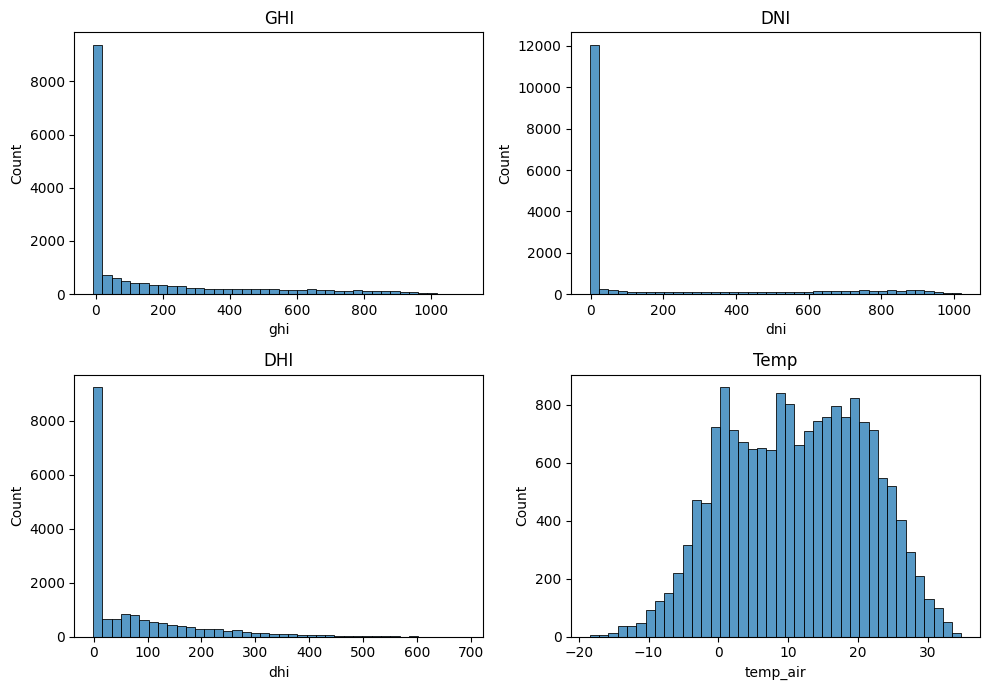

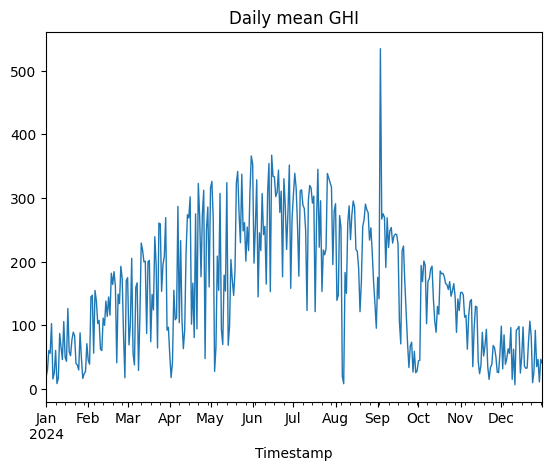

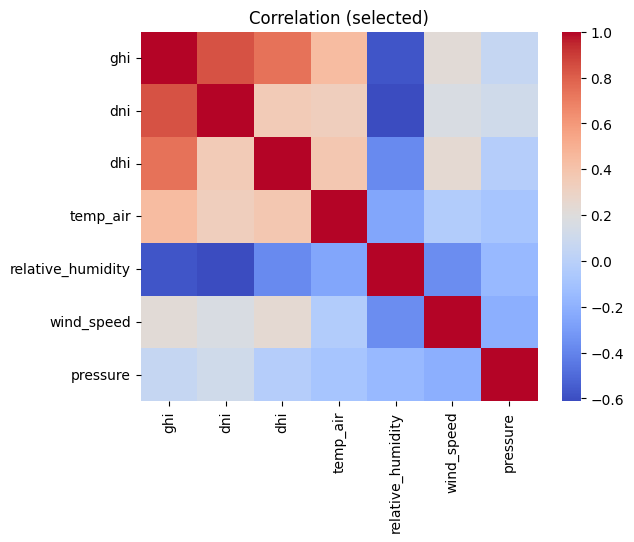

In [18]:
# Cell 3 — quick EDA

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df_eda = df.copy()

# Basic shape + time range + cadence
print("Rows, cols:", df_eda.shape)
if "Timestamp" in df_eda.columns:
    tmin, tmax = df_eda["Timestamp"].min(), df_eda["Timestamp"].max()
    step_med = (df_eda["Timestamp"].sort_values().diff().dropna().median())
    print("Time span:", tmin, "→", tmax)
    print("Median time step:", step_med)

# Picking required columns for project
cands = {
    "ghi": ["GHI (W/m²)", "ghi"],
    "dni": ["DNI (W/m²)", "dni"],
    "dhi": ["DHI (W/m²)", "dhi"],
    "temp": ["Temp (°C)", "temp_air"],
    "rh": ["RH (%)", "relative_humidity"],
    "ws": ["Wind Speed (m/s)", "wind_speed"],
    "pres": ["Pressure (hPa)", "pressure"],
    "sza": ["Solar Zenith Angle (°)", "solar_zenith"],
}
cols = {}
for k, opts in cands.items():
    for c in opts:
        if c in df_eda.columns:
            cols[k] = c
            break

sel = [c for c in cols.values()]
print("\nSelected columns for a quick look:", sel)

# Missing values + quick stats
if sel:
    print("\nMissing (selected):")
    print(df_eda[sel].isna().sum().sort_values(ascending=False))

    print("\nSummary stats (selected):")
    print(df_eda[sel].describe().T[["mean", "std", "min", "50%", "max"]])

# Distributions
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axlist = axes.ravel()
plots = [("ghi", "GHI"), ("dni", "DNI"), ("dhi", "DHI"), ("temp", "Temp")]
i = 0
for key, title in plots:
    if key in cols:
        sns.histplot(df_eda[cols[key]].dropna(), bins=40, ax=axlist[i])
        axlist[i].set_title(title)
        i += 1
for j in range(i, 4):
    axlist[j].axis("off")
plt.tight_layout()
plt.show()

# Daily pattern (sanity check for seasonality)
if "Timestamp" in df_eda.columns and "ghi" in cols:
    daily_mean = df_eda.set_index("Timestamp")[cols["ghi"]].resample("D").mean()
    daily_mean.plot(title="Daily mean GHI", lw=1)
    plt.show()

# Small correlation heatmap on selected numeric features
num = [cols.get(k) for k in ["ghi", "dni", "dhi", "temp", "rh", "ws", "pres"] if cols.get(k)]
if num:
    corr = df_eda[num].corr()
    sns.heatmap(corr, cmap="coolwarm", annot=False)
    plt.title("Correlation (selected)")
    plt.show()


In [19]:
# Cell 4 — Data Preprocessing: clean daylight series and build next-hour target
import numpy as np
import pandas as pd

# start from df produced in Cell 2
work = df.copy()

# 1) drop all *_flag columns (they're QC flags; we keep only the signals)
work = work[[c for c in work.columns if not c.endswith('_flag')]]

# 2) rename a few core columns to the friendlier names we used before
rename = {
    'ghi': 'GHI (W/m²)',
    'dni': 'DNI (W/m²)',
    'dhi': 'DHI (W/m²)',
    'temp_air': 'Temp (°C)',
    'relative_humidity': 'RH (%)',
    'pressure': 'Pressure (hPa)',
    'wind_speed': 'Wind Speed (m/s)',
    'wind_direction': 'Wind Direction (°)',
    'solar_zenith': 'Solar Zenith Angle (°)'
}
work = work.rename(columns=rename)

# 3) clip to physically plausible ranges
bounds = {
    'GHI (W/m²)': (0, 1400),
    'DNI (W/m²)': (0, 1200),
    'DHI (W/m²)': (0, 800),
    'RH (%)': (0, 100),
    'Temp (°C)': (-40, 50),
    'Pressure (hPa)': (850, 1100),
    'Wind Speed (m/s)': (0, 60),
    'Solar Zenith Angle (°)': (0, 180)
}
for col, (lo, hi) in bounds.items():
    if col in work.columns:
        work[col] = work[col].clip(lower=lo, upper=hi)

# 4) daylight filter (keeps learning focused on sunlit periods)
daylight_mask = False
if 'Solar Zenith Angle (°)' in work.columns:
    daylight_mask = (work['Solar Zenith Angle (°)'] < 90)
for c in ['GHI (W/m²)', 'DNI (W/m²)', 'DHI (W/m²)']:
    if c in work.columns:
        daylight_mask = daylight_mask | (work[c] > 20)

work = work.loc[daylight_mask].sort_values('Timestamp').reset_index(drop=True)

# 5) impute short gaps for numeric columns (light-touch)
num_cols = work.select_dtypes(include=['number']).columns.tolist()
# wind direction is circular; simplest is forward/back fill
if 'Wind Direction (°)' in num_cols:
    num_cols.remove('Wind Direction (°)')

work[num_cols] = (work[num_cols]
                  .interpolate(limit=3)   # small linear fills
                  .bfill(limit=1)
                  .ffill(limit=1))

if 'Wind Direction (°)' in work.columns:
    work['Wind Direction (°)'] = work['Wind Direction (°)'].ffill().bfill()

# 6) build next-hour target (30-min cadence -> shift by 2)
work['Target_GHI_NextHour (W/m²)'] = work['GHI (W/m²)'].shift(-2)
work = work.dropna(subset=['Target_GHI_NextHour (W/m²)']).reset_index(drop=True)

# 7) simple time features for all models
work['hour_float'] = work['Timestamp'].dt.hour + work['Timestamp'].dt.minute/60.0
work['hour_sin'] = np.sin(2*np.pi*work['hour_float']/24.0)
work['hour_cos'] = np.cos(2*np.pi*work['hour_float']/24.0)
work['doy'] = work['Timestamp'].dt.dayofyear
work['doy_sin'] = np.sin(2*np.pi*work['doy']/365.0)
work['doy_cos'] = np.cos(2*np.pi*work['doy']/365.0)

# 8) quick sanity print
print("After cleaning (daylight only):", work.shape)
print("Remaining NaNs (top 8):")
print(work.isna().sum().sort_values(ascending=False).head(8))

# 9) save a clean base (no labels yet). We'll create labels later in a separate cell.
CLEAN_PATH = "/content/solar_data_2024_30min_clean.csv"
work.to_csv(CLEAN_PATH, index=False)
print("Saved cleaned base to:", CLEAN_PATH)

# peek
display(work.head())


After cleaning (daylight only): (8775, 36)
Remaining NaNs (top 8):
totalnet      74
uvb           64
uw_solar      61
DHI (W/m²)    61
netsolar      61
DNI (W/m²)    61
dw_ir         13
netir         13
dtype: int64
Saved cleaned base to: /content/solar_data_2024_30min_clean.csv


,Timestamp,year,jday,month,day,hour,minute,dt,Solar Zenith Angle (°),GHI (W/m²),...,Wind Speed (m/s),Wind Direction (°),Pressure (hPa),Target_GHI_NextHour (W/m²),hour_float,hour_sin,hour_cos,doy,doy_sin,doy_cos
0,2024-01-01 12:30:00+00:00,2024.0,1.0,1.0,1.0,12.0,44.5,12.741667,89.173333,2.073333,...,0.566667,244.816667,971.750000,28.610000,12.5,-0.130526,-0.991445,1,0.017213,0.999852
1,2024-01-01 13:00:00+00:00,2024.0,1.0,1.0,1.0,13.0,14.5,13.241667,84.632667,15.190000,...,1.073333,242.850000,971.983333,54.383333,13.0,-0.258819,-0.965926,1,0.017213,0.999852
2,2024-01-01 13:30:00+00:00,2024.0,1.0,1.0,1.0,13.0,44.5,13.741667,80.306667,28.610000,...,2.053333,237.193333,972.303333,96.816667,13.5,-0.382683,-0.923880,1,0.017213,0.999852
3,2024-01-01 14:00:00+00:00,2024.0,1.0,1.0,1.0,14.0,14.5,14.241667,76.306000,54.383333,...,2.606667,247.283333,972.623333,238.410000,14.0,-0.500000,-0.866025,1,0.017213,0.999852
4,2024-01-01 14:30:00+00:00,2024.0,1.0,1.0,1.0,14.0,44.5,14.741667,72.726333,96.816667,...,3.070000,255.060000,972.840000,61.920000,14.5,-0.608761,-0.793353,1,0.017213,0.999852


In [20]:
# Cell 5 — feature engineering on the cleaned daylight data in `work`
import numpy as np
import pandas as pd

fe = work.copy()  # work comes from Cell 4

# 1) keep core signals (drop the miscellaneous long-tail radiation channels)
core_keep = [
    'Timestamp',
    'GHI (W/m²)', 'DNI (W/m²)', 'DHI (W/m²)',
    'Temp (°C)', 'RH (%)', 'Pressure (hPa)',
    'Wind Speed (m/s)', 'Wind Direction (°)',
    'Solar Zenith Angle (°)',
    'hour_float', 'hour_sin', 'hour_cos', 'doy', 'doy_sin', 'doy_cos',
    'Target_GHI_NextHour (W/m²)'
]
fe = fe[[c for c in core_keep if c in fe.columns]].sort_values('Timestamp').reset_index(drop=True)

# 2) cloudiness proxies (safe, bounded)
eps = 1e-6
gh = fe['GHI (W/m²)'].clip(lower=0) + eps
fe['diffuse_fraction'] = (fe['DHI (W/m²)'].clip(lower=0) / gh).clip(0, 1.2)   # a bit >1 possible under very cloudy spikes
fe['beam_fraction']    = (1.0 - fe['diffuse_fraction']).clip(0, 1.0)

# 3) lags & rolling means for a small set of variables
lag_cols = ['GHI (W/m²)', 'DNI (W/m²)', 'DHI (W/m²)',
            'Temp (°C)', 'RH (%)', 'Pressure (hPa)', 'Wind Speed (m/s)']

for c in lag_cols:
    fe[f'{c}_lag1'] = fe[c].shift(1)
    fe[f'{c}_lag2'] = fe[c].shift(2)

roll3 = fe[lag_cols].rolling(window=3, min_periods=1).mean().add_suffix('_roll3_mean')
roll6 = fe[lag_cols].rolling(window=6, min_periods=1).mean().add_suffix('_roll6_mean')
fe = pd.concat([fe, roll3, roll6], axis=1)

# 4) first differences (recent change)
for c in ['GHI (W/m²)', 'DNI (W/m²)', 'DHI (W/m²)']:
    fe[f'{c}_diff1'] = fe[c].diff(1)

# 5) drop rows made NaN by lags/rolling (first ~2 rows)
before = len(fe)
fe = fe.dropna().reset_index(drop=True)
dropped = before - len(fe)

print(f'Dropped {dropped} rows due to lags/rollings; remaining {len(fe)}')
print('Num features:', fe.shape[1])

# 6) save feature set for next steps (labels, split, models)
FEAT_PATH = "/content/solar_data_2024_30min_features.csv"
fe.to_csv(FEAT_PATH, index=False)
print("Saved features to:", FEAT_PATH)

display(fe.head(3))


Dropped 86 rows due to lags/rollings; remaining 8689
Num features: 50
Saved features to: /content/solar_data_2024_30min_features.csv


,Timestamp,GHI (W/m²),DNI (W/m²),DHI (W/m²),Temp (°C),RH (%),Pressure (hPa),Wind Speed (m/s),Wind Direction (°),Solar Zenith Angle (°),...,GHI (W/m²)_roll6_mean,DNI (W/m²)_roll6_mean,DHI (W/m²)_roll6_mean,Temp (°C)_roll6_mean,RH (%)_roll6_mean,Pressure (hPa)_roll6_mean,Wind Speed (m/s)_roll6_mean,GHI (W/m²)_diff1,DNI (W/m²)_diff1,DHI (W/m²)_diff1
0,2024-01-01 13:30:00+00:00,28.610000,0.226667,28.773333,0.186667,98.446667,972.303333,2.053333,237.193333,80.306667,...,15.291111,0.247778,15.723333,0.046667,98.463333,972.012222,1.231111,13.420000,0.010000,13.220000
1,2024-01-01 14:00:00+00:00,54.383333,0.273333,54.273333,0.676667,95.873333,972.623333,2.606667,247.283333,76.306000,...,25.064167,0.254167,25.360833,0.204167,97.815833,972.165000,1.575000,25.773333,0.046667,25.500000
2,2024-01-01 14:30:00+00:00,96.816667,0.310000,96.016667,1.086667,89.483333,972.840000,3.070000,255.060000,72.726333,...,39.414667,0.265333,39.492000,0.380667,96.149333,972.300000,1.874000,42.433333,0.036667,41.743333


## Data split



In [21]:
# Cell 6 — labels + time-safe split
import numpy as np
import pandas as pd

# If you just ran Cell 5 you already have `fe` in memory.
# Otherwise uncomment the next 2 lines to reload the features we saved.
# FEAT_PATH = "/content/solar_data_2024_30min_features.csv"
# fe = pd.read_csv(FEAT_PATH, parse_dates=["Timestamp"])

df = fe.copy().sort_values("Timestamp").reset_index(drop=True)

# ---- 1) wind direction is circular: convert to components, then drop raw angle
if {"Wind Speed (m/s)", "Wind Direction (°)"}.issubset(df.columns):
    rad = np.deg2rad(df["Wind Direction (°)"].clip(0, 360))
    df["wind_u"] = df["Wind Speed (m/s)"] * np.sin(rad)
    df["wind_v"] = df["Wind Speed (m/s)"] * np.cos(rad)
    df = df.drop(columns=["Wind Direction (°)"], errors="ignore")

# ---- 2) choose label mode
# "fixed": bins you used earlier (imbalanced, realistic)
# "adaptive": tertiles learned from the TRAIN split only (balanced)
LABEL_MODE = "fixed"   # change to "adaptive" if you want balanced classes

target_reg = "Target_GHI_NextHour (W/m²)"

# time-safe split: last 20% as test (no shuffling)
test_size = 0.20
split_idx = int((1 - test_size) * len(df))
df_train = df.iloc[:split_idx].copy()
df_test  = df.iloc[split_idx:].copy()

# ---- 3) build labels
labels = ["Low", "Medium", "High"]

if LABEL_MODE == "fixed":
    # Keep exactly what we printed when creating the CSVs
    bins = [0, 250, 600, np.inf]
    df_train["ghi_category"] = pd.cut(df_train[target_reg], bins=bins, labels=labels, include_lowest=True)
    df_test["ghi_category"]  = pd.cut(df_test[target_reg],  bins=bins, labels=labels, include_lowest=True)

elif LABEL_MODE == "adaptive":
    # Learn cutpoints on TRAIN ONLY (no leakage), then apply to test
    q33 = float(df_train[target_reg].quantile(1/3))
    q66 = float(df_train[target_reg].quantile(2/3))
    bins = [0, max(1e-6, q33), max(q33 + 1e-6, q66), np.inf]
    df_train["ghi_category"] = pd.cut(df_train[target_reg], bins=bins, labels=labels, include_lowest=True)
    df_test["ghi_category"]  = pd.cut(df_test[target_reg],  bins=bins, labels=labels, include_lowest=True)
else:
    raise ValueError("LABEL_MODE must be 'fixed' or 'adaptive'")

# small sanity check
print("Split index:", split_idx, "| train rows:", len(df_train), "| test rows:", len(df_test))
print("\nTrain class counts:")
print(df_train["ghi_category"].value_counts(dropna=False))
print("\nTest class counts:")
print(df_test["ghi_category"].value_counts(dropna=False))

# ---- 4) select feature columns (drop non-features + label + timestamp)
drop_cols = {"Timestamp", target_reg, "ghi_category"}
X_cols = [c for c in df.columns if c not in drop_cols]

X_train = df_train[X_cols].to_numpy()
y_train = df_train["ghi_category"].astype("category").cat.codes.to_numpy()  # Low=0, Medium=1, High=2
X_test  = df_test[X_cols].to_numpy()
y_test  = df_test["ghi_category"].astype("category").cat.codes.to_numpy()

# class weights for imbalanced training (used by XGBClassifier later)
from collections import Counter
cnt = Counter(y_train)
n_total = len(y_train)
n_cls = len(cnt)
class_weight = {k: n_total / (n_cls * v) for k, v in cnt.items()}
print("\nEncoded classes (0,1,2) ->", df_train["ghi_category"].astype("category").cat.categories.tolist())
print("Class weights:", class_weight)

# ---- 5) stash everything for the next cells
data_pack = {
    "X_cols": X_cols,
    "X_train": X_train, "y_train": y_train,
    "X_test":  X_test,  "y_test":  y_test,
    "train_df": df_train, "test_df": df_test,
    "bins_used": bins, "label_mode": LABEL_MODE
}
print("\nFeatures ready. X_train/X_test shapes:", X_train.shape, X_test.shape)


Split index: 6951 | train rows: 6951 | test rows: 1738

Train class counts:
ghi_category
Low       3367
Medium    1978
High      1606
Name: count, dtype: int64

Test class counts:
ghi_category
Low       1093
Medium     557
High        88
Name: count, dtype: int64

Encoded classes (0,1,2) -> ['Low', 'Medium', 'High']
Class weights: {np.int8(0): 0.6881496881496881, np.int8(1): 1.1713852376137512, np.int8(2): 1.4427148194271482}

Features ready. X_train/X_test shapes: (6951, 49) (1738, 49)


## EDA

## Model 1: XGBClassifier

XGBoost version: 3.0.4
Train/Test: (6951, 49) (1738, 49)
Class weights (train): {0: 0.6251644253908227, 1: 1.06417018214909, 2: 1.3106653924600873}

=== Persistence baseline (bin of current GHI) ===
Accuracy   : 0.7819
Macro-F1   : 0.6863
Weighted-F1: 0.7820

Report:
               precision    recall  f1-score   support

         Low       0.86      0.86      0.86      1093
      Medium       0.66      0.66      0.66       557
        High       0.53      0.53      0.53        88

    accuracy                           0.78      1738
   macro avg       0.69      0.69      0.69      1738
weighted avg       0.78      0.78      0.78      1738



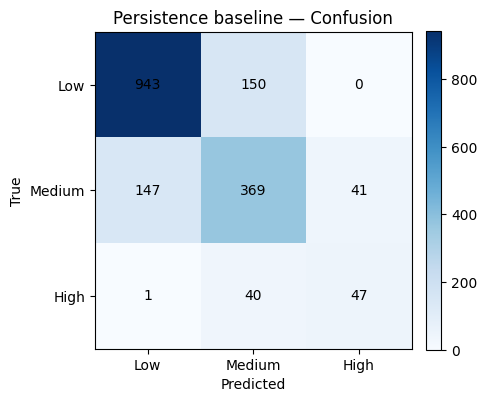

In [22]:
# keep imports local to this block so the cell reads self-contained
import time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
from sklearn.model_selection import ParameterSampler
from sklearn.preprocessing import LabelBinarizer

import xgboost as xgb

# ---- sanity checks from earlier cells ----
print("XGBoost version:", xgb.__version__)
print("Train/Test:", X_train.shape, X_test.shape)

# Small helpers I’ll reuse
def class_weights_from_counts(y):
    """inverse-frequency weights per class (dict: class_idx -> weight)"""
    counts = pd.Series(y).value_counts().sort_index()
    w = (counts.sum() / counts).to_dict()
    # normalize to mean 1.0 (nicer scale)
    mean_w = np.mean(list(w.values()))
    w = {k: float(v / mean_w) for k, v in w.items()}
    return w

def onehot(y, n_classes=3):
    lb = LabelBinarizer()
    lb.fit(range(n_classes))
    return lb.transform(y)

def macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def report_block(y_true, y_pred, title):
    acc   = accuracy_score(y_true, y_pred)
    f1_ma = f1_score(y_true, y_pred, average="macro")
    f1_wt = f1_score(y_true, y_pred, average="weighted")
    print(f"\n=== {title} ===")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Macro-F1   : {f1_ma:.4f}")
    print(f"Weighted-F1: {f1_wt:.4f}")
    print("\nReport:\n", classification_report(y_true, y_pred, target_names=["Low","Medium","High"]))
    return {"accuracy":acc, "macro_f1":f1_ma, "weighted_f1":f1_wt}

def plot_confmat(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    fig, ax = plt.subplots(figsize=(4.8,4.2))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
    ax.set_xticklabels(["Low","Medium","High"])
    ax.set_yticklabels(["Low","Medium","High"])
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    for i in range(3):
        for j in range(3):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

# We’ll need a quick way to grab a feature column by name even if X_* are arrays.
def get_col(arr_or_df, colname, feature_names):
    if hasattr(arr_or_df, "loc"):
        return arr_or_df[colname].to_numpy()
    idx = feature_names.index(colname)
    return arr_or_df[:, idx]

# Class weights from *your* train set (time-safe)
cls_w = class_weights_from_counts(y_train)
print("Class weights (train):", cls_w)

# ---- (optional but useful) Persistence baseline: "bin current GHI" ----
# If your features include raw current GHI, we can baseline against a simple rule.
baseline_scores = None
if "GHI (W/m²)" in X_cols:
    ghi_now_test = get_col(X_test, "GHI (W/m²)", X_cols)
    y_baseline = np.where(ghi_now_test < 250, 0, np.where(ghi_now_test < 600, 1, 2)).astype(np.int8)
    baseline_scores = report_block(y_test, y_baseline, "Persistence baseline (bin of current GHI)")
    plot_confmat(y_test, y_baseline, "Persistence baseline — Confusion")
else:
    print("Note: raw 'GHI (W/m²)' not in X_cols → skipping persistence baseline.")

# To make feature names usable with XGB’s importance later, convert to DataFrame once here.
Xtr_df = pd.DataFrame(X_train, columns=X_cols)
Xte_df = pd.DataFrame(X_test,  columns=X_cols)


XGBoost version: 3.0.4
[05/30] CV macro-F1(best so far): 0.784
[10/30] CV macro-F1(best so far): 0.789
[15/30] CV macro-F1(best so far): 0.791
[20/30] CV macro-F1(best so far): 0.791
[25/30] CV macro-F1(best so far): 0.791
[30/30] CV macro-F1(best so far): 0.791

Best CV macro-F1: 0.791
Best params: {'subsample': np.float64(0.95), 'reg_lambda': 10.0, 'reg_alpha': 0.1, 'min_child_weight': np.float64(2.0), 'max_depth': 4, 'learning_rate': 0.1, 'gamma': np.float64(1.0), 'colsample_bytree': np.float64(0.6)}
Avg early-stopped rounds (CV): 91
Tuning time: 356.5s


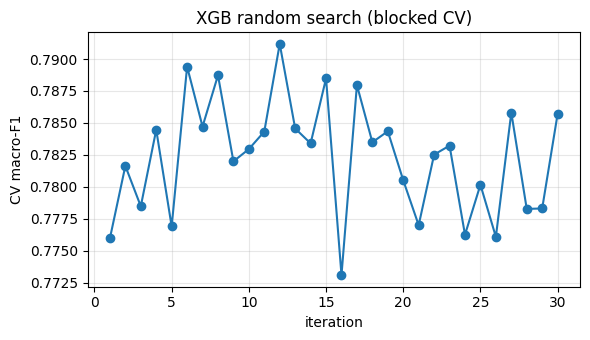

In [24]:
# Cell 8 — CV + random search with version-proof early stopping
import time, json
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import f1_score

print("XGBoost version:", xgb.__version__)

# ---- helpers we need ONLY here ----
def blocked_cv_indices(n_rows, n_splits=4):
    """Contiguous forward folds (no shuffling) to respect time order."""
    fold_sizes = np.full(n_splits, n_rows // n_splits, dtype=int)
    fold_sizes[: n_rows % n_splits] += 1
    idx = np.arange(n_rows)
    cur = 0
    blocks = []
    for fs in fold_sizes:
        blocks.append(idx[cur:cur+fs])
        cur += fs
    for i in range(n_splits):
        val = blocks[i]
        tr  = np.concatenate(blocks[:i]) if i > 0 else np.array([], dtype=int)
        if tr.size == 0:  # skip the first empty-train fold
            continue
        yield tr, val

class _BoosterWrap:
    """Make xgb.train booster look like sklearn estimator for our code path."""
    def __init__(self, booster):
        self._booster = booster
        # xgb.train sets either best_ntree_limit or best_iteration
        self.best_iteration_ = getattr(booster, "best_iteration", None)
    def predict_proba(self, X):
        d = xgb.DMatrix(np.asarray(X))
        return self._booster.predict(d)
    def predict(self, X):
        P = self.predict_proba(X)
        return P.argmax(axis=1)
    def evals_result(self):
        try:
            return self._booster.evals_result()
        except Exception:
            return {}
    def get_booster(self):
        return self._booster

def _fit_with_es(model, Xtr, ytr, wtr, Xva, yva, es_rounds):
    """Try several ways to do early stopping depending on XGBoost version."""
    # try 1: sklearn API with early_stopping_rounds
    try:
        model.fit(
            Xtr, ytr,
            sample_weight=wtr,
            eval_set=[(Xva, yva)],
            early_stopping_rounds=es_rounds,
            verbose=False
        )
        return model
    except TypeError:
        pass

    # try 2: sklearn API with callbacks
    try:
        from xgboost.callback import EarlyStopping
        cb = [EarlyStopping(rounds=es_rounds, save_best=True)]
        model.fit(
            Xtr, ytr,
            sample_weight=wtr,
            eval_set=[(Xva, yva)],
            callbacks=cb,
            verbose=False
        )
        return model
    except Exception:
        pass

    # try 3: native xgb.train with DMatrix and early_stopping_rounds
    dtr = xgb.DMatrix(np.asarray(Xtr), label=ytr, weight=wtr)
    dva = xgb.DMatrix(np.asarray(Xva), label=yva)
    # translate sklearn params to booster params
    p = {
        "objective": "multi:softprob",
        "num_class": 3,
        "tree_method": "hist",
        "eval_metric": "mlogloss",
        "eta": model.get_params().get("learning_rate", 0.1),
        "max_depth": model.get_params().get("max_depth", 6),
        "min_child_weight": model.get_params().get("min_child_weight", 1.0),
        "subsample": model.get_params().get("subsample", 1.0),
        "colsample_bytree": model.get_params().get("colsample_bytree", 1.0),
        "gamma": model.get_params().get("gamma", 0.0),
        "alpha": model.get_params().get("reg_alpha", 0.0),
        "lambda": model.get_params().get("reg_lambda", 1.0),
        "verbosity": 0,
    }
    num_round = model.get_params().get("n_estimators", 2000)
    booster = xgb.train(
        p, dtr, num_boost_round=num_round,
        evals=[(dtr, "train"), (dva, "validation_0")],
        early_stopping_rounds=es_rounds,
        verbose_eval=False
    )
    return _BoosterWrap(booster)

def _macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def cv_score(params, X_df, y, n_splits=4, early_rounds=200, class_weight_dict=None):
    f1s, rounds = [], []
    for tr_idx, va_idx in blocked_cv_indices(len(X_df), n_splits=n_splits):
        Xtr, Xva = X_df.iloc[tr_idx], X_df.iloc[va_idx]
        ytr, yva = y[tr_idx], y[va_idx]
        wtr = np.vectorize(class_weight_dict.get)(ytr) if class_weight_dict else None

        model = xgb.XGBClassifier(
            objective="multi:softprob",
            num_class=3,
            tree_method="hist",
            eval_metric="mlogloss",
            n_estimators=2500,             # upper bound, ES will cut
            random_state=42,
            n_jobs=-1,
            **params
        )
        fitted = _fit_with_es(model, Xtr, ytr, wtr, Xva, yva, early_rounds)
        yv_hat = fitted.predict(Xva)
        f1s.append(_macro_f1(yva, yv_hat))
        bi = getattr(fitted, "best_iteration_", None)
        rounds.append(int(bi) if bi is not None else int(model.get_params().get("n_estimators", 0)))
    return float(np.mean(f1s)), int(np.mean(rounds))

# ---- search space (compact but effective) ----
search_space = {
    "max_depth":        [3, 4, 5, 6],
    "min_child_weight": np.linspace(1.0, 7.0, 7),
    "subsample":        np.linspace(0.7, 1.0, 7),
    "colsample_bytree": np.linspace(0.6, 1.0, 9),
    "learning_rate":    [0.03, 0.06, 0.1, 0.15],
    "gamma":            np.linspace(0.0, 1.0, 6),
    "reg_alpha":        [0.0, 0.001, 0.01, 0.1],
    "reg_lambda":       [0.01, 0.1, 1.0, 5.0, 10.0],
}

# we reuse class weights computed earlier in Cell 7 as `cls_w`
history = []
best = (-1.0, None, None)

t0 = time.time()
n_iter = 30  # bump to 60–100 if you want more thorough search
for i, params in enumerate(ParameterSampler(search_space, n_iter=n_iter, random_state=42), 1):
    start = time.time()
    score, mean_rounds = cv_score(params, Xtr_df, y_train, n_splits=4, early_rounds=200, class_weight_dict=cls_w)
    dur = time.time() - start
    history.append({"iter": i, "macro_f1": score, "mean_best_rounds": mean_rounds, **params, "seconds": dur})
    if score > best[0]:
        best = (score, params, mean_rounds)
    if i % 5 == 0 or i == n_iter:
        print(f"[{i:02d}/{n_iter}] CV macro-F1(best so far): {max(h['macro_f1'] for h in history):.3f}")

t_tune = time.time() - t0
best_score, best_params, best_rounds = best
print("\nBest CV macro-F1:", f"{best_score:.3f}")
print("Best params:", best_params)
print("Avg early-stopped rounds (CV):", best_rounds)
print(f"Tuning time: {t_tune:.1f}s")

# keep a CSV + quick plot for your write-up
hist_df = pd.DataFrame(history).sort_values("iter")
hist_df.to_csv("xgb_tuning_history.csv", index=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,3.5))
plt.plot(hist_df["iter"], hist_df["macro_f1"], marker="o")
plt.xlabel("iteration"); plt.ylabel("CV macro-F1"); plt.title("XGB random search (blocked CV)")
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


Best iteration (final): 239

=== XGB (prob-argmax) — Test ===
Accuracy   : 0.8078
Macro-F1   : 0.7106
Weighted-F1: 0.8222

Report:
               precision    recall  f1-score   support

         Low       0.96      0.86      0.91      1093
      Medium       0.72      0.67      0.70       557
        High       0.36      0.98      0.53        88

    accuracy                           0.81      1738
   macro avg       0.68      0.84      0.71      1738
weighted avg       0.85      0.81      0.82      1738



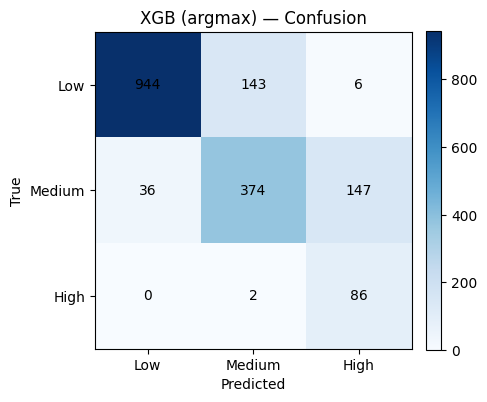

Calibrated class weights on val: (1.15, 0.7, 0.7) → macro-F1: 0.848

=== XGB (calibrated) — Test ===
Accuracy   : 0.8228
Macro-F1   : 0.7191
Weighted-F1: 0.8347

Report:
               precision    recall  f1-score   support

         Low       0.95      0.90      0.93      1093
      Medium       0.77      0.65      0.71       557
        High       0.36      0.98      0.53        88

    accuracy                           0.82      1738
   macro avg       0.69      0.84      0.72      1738
weighted avg       0.87      0.82      0.83      1738



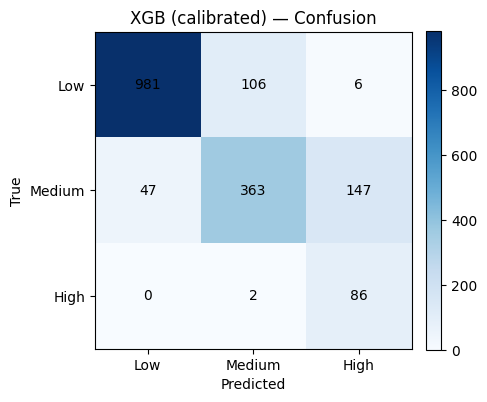

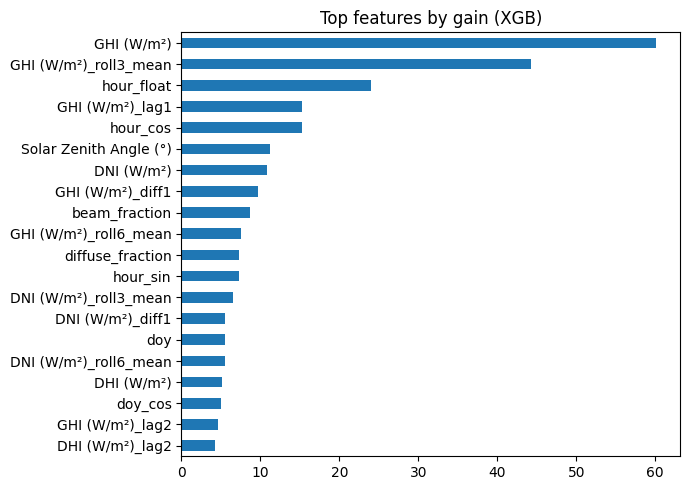

,track,model,label_mode,cv_macro_f1,val_macro_f1_cal,test_acc_argmax,test_macro_f1_argmax,test_weighted_f1_argmax,test_acc_cal,test_macro_f1_cal,...,fit_time_sec,pred_time_sec,acc_argmax,macroF1_argmax,weightedF1_argmax,acc_cal,macroF1_cal,weightedF1_cal,best_iter,best_params
0,classification,XGBClassifier,fixed,0.799193,0.862905,0.821059,0.720551,0.833079,0.842348,0.752343,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,XGBClassifier,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.975,0.015,0.8078,0.7106,0.8222,0.8228,0.7191,0.8347,239.0,"{""subsample"": 0.95, ""reg_lambda"": 10.0, ""reg_a..."



Saved:
  • xgb_tuning_history.csv
  • model_benchmarks.csv


In [25]:
# Cell 9 — final training + evaluation + calibration + artifacts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)

def report_block(y_true, y_pred, title):
    acc   = accuracy_score(y_true, y_pred)
    f1_ma = f1_score(y_true, y_pred, average="macro")
    f1_wt = f1_score(y_true, y_pred, average="weighted")
    print(f"\n=== {title} ===")
    print(f"Accuracy   : {acc:.4f}")
    print(f"Macro-F1   : {f1_ma:.4f}")
    print(f"Weighted-F1: {f1_wt:.4f}")
    print("\nReport:\n", classification_report(y_true, y_pred, target_names=["Low","Medium","High"]))
    return {"accuracy":acc, "macro_f1":f1_ma, "weighted_f1":f1_wt}

def plot_confmat(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    fig, ax = plt.subplots(figsize=(4.8,4.2))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
    ax.set_xticklabels(["Low","Medium","High"])
    ax.set_yticklabels(["Low","Medium","High"])
    ax.set_xlabel("Predicted"); ax.set_ylabel("True"); ax.set_title(title)
    for i in range(3):
        for j in range(3):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

def apply_calibration(P, alpha=(1.0,1.0,1.0)):
    P = P * np.asarray(alpha)[None, :]
    P = P / P.sum(axis=1, keepdims=True)
    return P

# split tail of train as validation (time-safe)
cut = int(0.9 * len(Xtr_df))
Xtr_in, ytr_in = Xtr_df.iloc[:cut], y_train[:cut]
Xva_in, yva_in = Xtr_df.iloc[cut:], y_train[cut:]
w_tr_in = np.vectorize(cls_w.get)(ytr_in)

final = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    tree_method="hist",
    eval_metric="mlogloss",
    n_estimators=3000,
    random_state=42,
    n_jobs=-1,
    **best_params
)

start = time.time()
final_fitted = _fit_with_es(final, Xtr_in, ytr_in, w_tr_in, Xva_in, yva_in, es_rounds=max(50, best_rounds))
t_fit = time.time() - start
best_iter = getattr(final_fitted, "best_iteration_", None)
print("Best iteration (final):", best_iter)

# learning curve (if available)
ev = {}
try:
    ev = final_fitted.evals_result()
except Exception:
    pass

if ev and "validation_0" in ev:
    plt.figure(figsize=(6,3.5))
    plt.plot(ev["validation_0"]["mlogloss"], label="val_logloss")
    if "train" in ev:
        plt.plot(ev["train"]["mlogloss"], label="train_logloss", alpha=0.7)
    plt.xlabel("trees"); plt.ylabel("logloss"); plt.title("XGB — learning curve"); plt.legend()
    plt.tight_layout(); plt.show()

# predict on test
t0 = time.time()
proba_test = final_fitted.predict_proba(Xte_df)
pred_argmax = proba_test.argmax(axis=1)
t_pred = time.time() - t0

scores_arg = report_block(y_test, pred_argmax, "XGB (prob-argmax) — Test")
plot_confmat(y_test, pred_argmax, "XGB (argmax) — Confusion")

# tiny probability calibration on validation tail (per-class multipliers)
proba_val = final_fitted.predict_proba(Xva_in)
grid = [0.7, 0.85, 1.0, 1.15, 1.3]
best_alpha, best_f1 = (1.0,1.0,1.0), -1.0
for a0 in grid:
    for a1 in grid:
        for a2 in grid:
            Pv = apply_calibration(proba_val, (a0,a1,a2))
            f1v = f1_score(yva_in, Pv.argmax(axis=1), average="macro")
            if f1v > best_f1:
                best_f1, best_alpha = f1v, (a0,a1,a2)

print(f"Calibrated class weights on val: {best_alpha} → macro-F1: {best_f1:.3f}")
pred_cal = apply_calibration(proba_test, best_alpha).argmax(axis=1)
scores_cal = report_block(y_test, pred_cal, "XGB (calibrated) — Test")
plot_confmat(y_test, pred_cal, "XGB (calibrated) — Confusion")

# feature importance (gain)
booster = final_fitted.get_booster()
gain_raw = booster.get_score(importance_type="gain")
name_map = {f"f{i}": c for i, c in enumerate(X_cols)}
gain = pd.Series({name_map.get(k, k): v for k, v in gain_raw.items()})
if not gain.empty:
    top = gain.sort_values(ascending=False).head(20)
    plt.figure(figsize=(7,5))
    top.sort_values().plot.barh()
    plt.title("Top features by gain (XGB)")
    plt.tight_layout(); plt.show()

# benchmarks table
row = {
    "model": "XGBClassifier",
    "train_rows": len(X_train),
    "test_rows": len(X_test),
    "fit_time_sec": round(t_fit, 3),
    "pred_time_sec": round(t_pred, 3),
    "acc_argmax": round(scores_arg["accuracy"], 4),
    "macroF1_argmax": round(scores_arg["macro_f1"], 4),
    "weightedF1_argmax": round(scores_arg["weighted_f1"], 4),
    "acc_cal": round(scores_cal["accuracy"], 4),
    "macroF1_cal": round(scores_cal["macro_f1"], 4),
    "weightedF1_cal": round(scores_cal["weighted_f1"], 4),
    "best_iter": int(best_iter) if best_iter is not None else None,
    "best_params": json.dumps({k: (float(v) if isinstance(v, np.generic) else v) for k,v in (best_params or {}).items()}),
}
try:
    prev = pd.read_csv("model_benchmarks.csv")
    bench = pd.concat([prev, pd.DataFrame([row])], ignore_index=True)
except Exception:
    bench = pd.DataFrame([row])
bench.to_csv("model_benchmarks.csv", index=False)
display(bench.tail(3))

print("\nSaved:")
print("  • xgb_tuning_history.csv")
print("  • model_benchmarks.csv")


## Random Forest Classifier (Full Build – From Scratch)

Label mode used: tertile
Class counts (train): {'Low': 2324, 'High': 2324, 'Medium': 2323}
Balancer used: SMOTE-Tomek
Class counts after balancing: {'High': 2156, 'Low': 2147, 'Medium': 1981}
Best RF params: {'n_estimators': 1500, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_samples': None, 'max_features': 0.6, 'max_depth': 16} (search 4143.4s)
Final fit time: 264.5s

RF (Enhanced) — Test  Acc:0.816  Prec:0.793  Rec:0.835  F1:0.807

Per-class report:
              precision    recall  f1-score   support

        High      0.668     0.911     0.771       282
         Low      0.900     0.870     0.885       738
      Medium      0.812     0.723     0.765       716

    accuracy                          0.816      1736
   macro avg      0.793     0.835     0.807      1736
weighted avg      0.826     0.816     0.817      1736



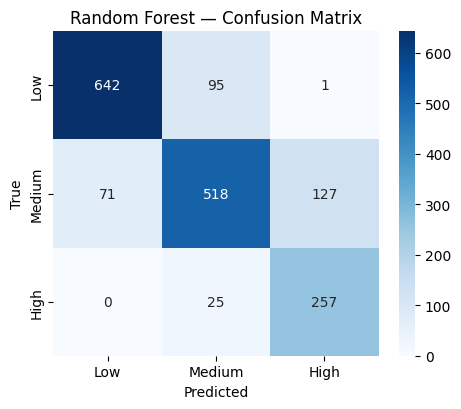

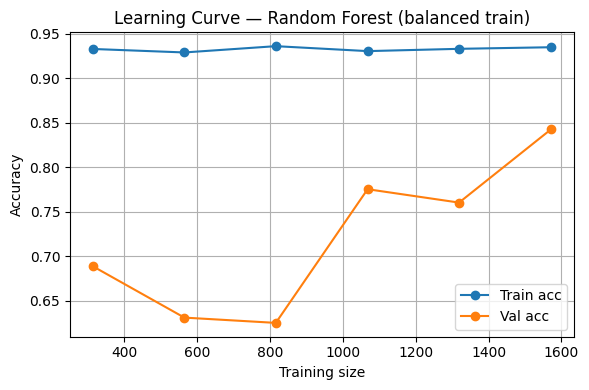

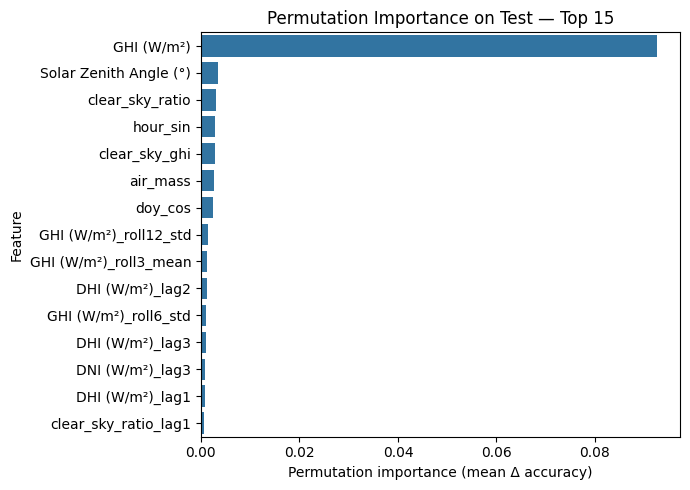

100%|===================| 899/900 [07:13<00:00]       

RF class order: ['High', 'Low', 'Medium']
SHAP summary for class: High


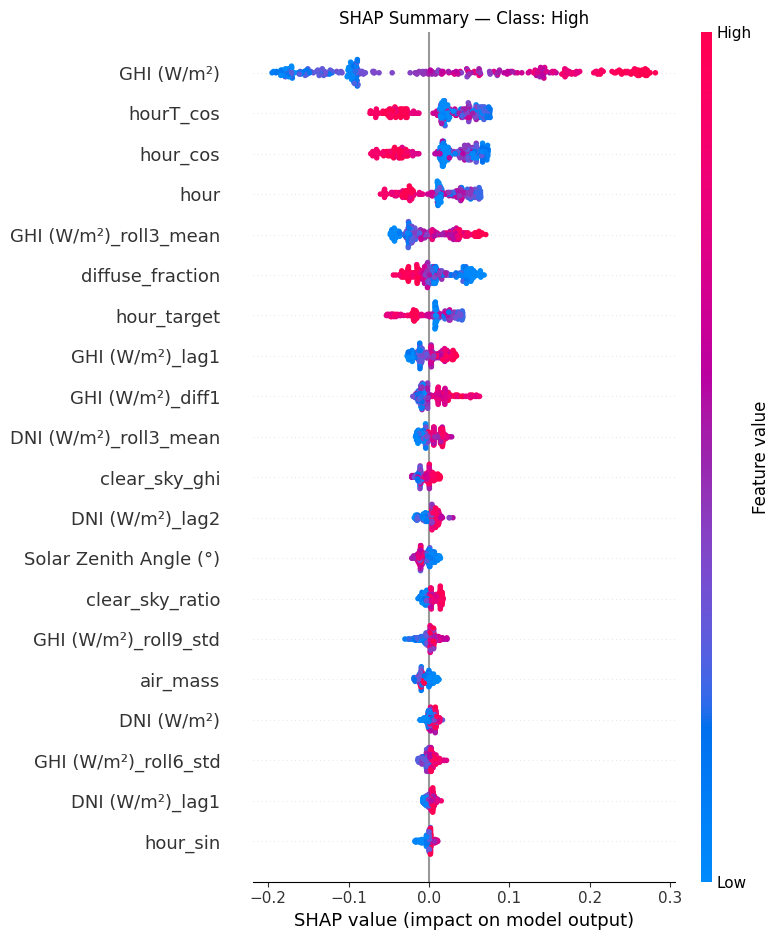

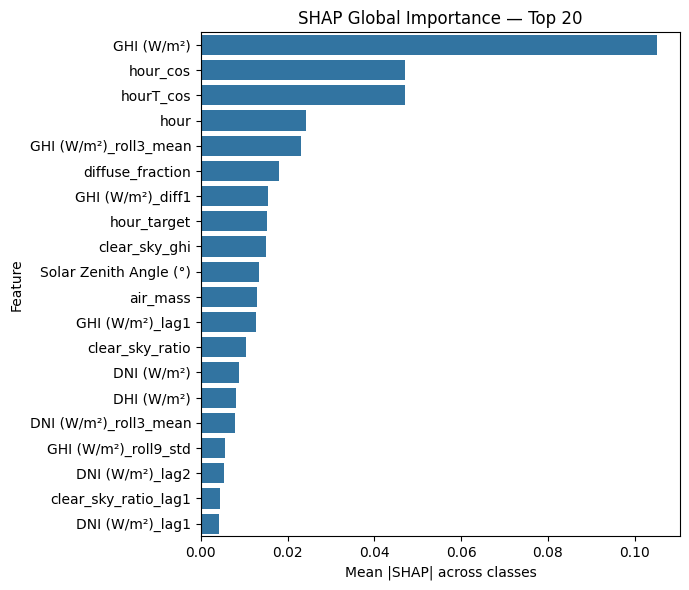

In [ ]:
# # Cell 8 — Random Forest (one cell: richer features + SMOTE-Tomek + TS tuning + diagnostics + SHAP)
# import time, numpy as np, pandas as pd
# import matplotlib.pyplot as plt, seaborn as sns

# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, learning_curve, cross_val_score
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
# from sklearn.inspection import permutation_importance

# # imbalance tools
# try:
#     from imblearn.combine import SMOTETomek
#     from imblearn.over_sampling import SMOTE
#     HAS_IMB = True
# except Exception:
#     HAS_IMB = False

# # SHAP
# try:
#     import shap
#     HAS_SHAP = True
# except Exception:
#     HAS_SHAP = False

# # ---------- helpers ----------
# def pick(options, cols):
#     for c in options:
#         if c in cols: return c
#     raise KeyError(f"None of {options} found. Have: {list(cols)}")

# def make_labels_auto(ytr_reg, Xtr_sc, tscv):
#     # compare domain thresholds vs tertiles quickly; pick the better on CV
#     def label_domain(v):
#         if v < 300: return "Low"
#         if v > 700: return "High"
#         return "Medium"
#     q1, q2 = ytr_reg.quantile([1/3, 2/3]).values
#     def label_ter(v):
#         if v <= q1: return "Low"
#         elif v <= q2: return "Medium"
#         else: return "High"

#     y_dom = ytr_reg.apply(label_domain)
#     y_ter = ytr_reg.apply(label_ter)

#     base = RandomForestClassifier(
#         n_estimators=400, max_depth=12, min_samples_leaf=12,
#         class_weight='balanced_subsample', n_jobs=-1, random_state=42
#     )
#     s_dom = cross_val_score(base, Xtr_sc, y_dom, cv=tscv, scoring='accuracy', n_jobs=-1).mean()
#     s_ter = cross_val_score(base, Xtr_sc, y_ter, cv=tscv, scoring='accuracy', n_jobs=-1).mean()
#     return (y_dom, 'domain') if s_dom >= s_ter else (y_ter, 'tertile'), (label_domain if s_dom>=s_ter else label_ter)

# # ---------- 1) copy + detect column names ----------
# df_ext = df_feat.copy()
# ghi_col  = pick(['ghi_w_m2','GHI (W/m²)'], df_ext.columns)
# temp_col = pick(['temp_c','Temp (°C)'], df_ext.columns)

# # ---------- 2) add extra lags/rollings ----------
# for lag in [1,2,3,4]:
#     df_ext[f'{ghi_col}_lag{lag}']  = df_ext[ghi_col].shift(lag)
#     df_ext[f'{temp_col}_lag{lag}'] = df_ext[temp_col].shift(lag)
# for win in [3,6,9,12]:
#     df_ext[f'{ghi_col}_roll{win}_mean'] = df_ext[ghi_col].rolling(win).mean()
#     df_ext[f'{ghi_col}_roll{win}_std']  = df_ext[ghi_col].rolling(win).std()

# # ---------- 3) daylight mask with index intersection ----------
# DAYLIGHT_ONLY = True
# if DAYLIGHT_ONLY and ('is_daylight' in df_ext.columns):
#     daylight_idx = df_ext.index[df_ext['is_daylight']==1]
# else:
#     daylight_idx = df_ext.index

# tr_idx = X_train.index.intersection(daylight_idx)
# te_idx = X_test.index.intersection(daylight_idx)

# Xtr_raw = df_ext.loc[tr_idx].copy().dropna()
# Xte_raw = df_ext.loc[te_idx].copy().dropna()

# ytr_reg = y_reg_train.loc[Xtr_raw.index]
# yte_reg = y_reg_test.loc[Xte_raw.index]

# # ---------- 4) build labels (auto choose) ----------
# non_feats = {'timestamp','Timestamp','ghi_category','Target_GHI_NextHour (W/m²)','target_ghi_nexthour_w_m2'}
# feat_cols = [c for c in Xtr_raw.columns if c not in non_feats]
# Xtr = Xtr_raw[feat_cols];  Xte = Xte_raw[feat_cols]

# scaler = StandardScaler()
# Xtr_sc = pd.DataFrame(scaler.fit_transform(Xtr), index=Xtr.index, columns=Xtr.columns)
# Xte_sc = pd.DataFrame(scaler.transform(Xte),    index=Xte.index, columns=Xte.columns)

# tscv_small = TimeSeriesSplit(n_splits=3)
# ((ytr_labels, label_mode), f_test_rule) = make_labels_auto(ytr_reg, Xtr_sc, tscv_small)
# yte_labels = yte_reg.apply(f_test_rule)
# print(f"Label mode used: {label_mode}")
# print("Class counts (train):", ytr_labels.value_counts().to_dict())

# # ---------- 5) balance train set (use DataFrame to preserve names) ----------
# if HAS_IMB:
#     try:
#         bal = SMOTETomek(random_state=42)
#         X_bal_np, y_bal = bal.fit_resample(Xtr_sc.values, ytr_labels.values)
#         balancer_name = "SMOTE-Tomek"
#     except Exception:
#         bal = SMOTE(random_state=42, k_neighbors=5)
#         X_bal_np, y_bal = bal.fit_resample(Xtr_sc.values, ytr_labels.values)
#         balancer_name = "SMOTE"
# else:
#     X_bal_np, y_bal = Xtr_sc.values, ytr_labels.values
#     balancer_name = "None"

# # rewrap to DataFrame so sklearn + SHAP keep names consistently
# train_feat_names = list(Xtr_sc.columns)
# X_bal = pd.DataFrame(X_bal_np, columns=train_feat_names)
# y_bal = pd.Series(y_bal, name='label')
# print(f"Balancer used: {balancer_name}")
# print("Class counts after balancing:", y_bal.value_counts().to_dict())

# # ---------- 6) tune RF with TimeSeriesSplit ----------
# rf = RandomForestClassifier(
#     random_state=42, n_jobs=-1, class_weight='balanced_subsample', bootstrap=True
# )
# param_dist = {
#     'n_estimators':      [600, 900, 1200, 1500],
#     'max_depth':         [8, 12, 16],
#     'min_samples_split': [10, 20, 40],
#     'min_samples_leaf':  [8, 12, 20],
#     'max_features':      ['sqrt', 0.4, 0.6],
#     'max_samples':       [None, 0.9, 0.7],
# }
# tscv = TimeSeriesSplit(n_splits=3)
# search = RandomizedSearchCV(
#     rf, param_distributions=param_dist, n_iter=32,
#     cv=tscv, scoring='accuracy', n_jobs=-1, random_state=42, verbose=0
# )

# t0 = time.time()
# search.fit(X_bal, y_bal)
# print("Best RF params:", search.best_params_, f"(search {time.time()-t0:.1f}s)")
# best_rf = search.best_estimator_
# best_rf.set_params(n_estimators=max(1500, best_rf.get_params()['n_estimators']))

# t1 = time.time()
# best_rf.fit(X_bal, y_bal)
# print(f"Final fit time: {time.time()-t1:.1f}s")

# # ---------- 7) evaluate ----------
# yp = best_rf.predict(Xte_sc)
# acc = accuracy_score(yte_labels, yp)
# prec, rec, f1, _ = precision_recall_fscore_support(yte_labels, yp, average='macro', zero_division=0)
# print(f"\nRF (Enhanced) — Test  Acc:{acc:.3f}  Prec:{prec:.3f}  Rec:{rec:.3f}  F1:{f1:.3f}")
# print("\nPer-class report:")
# print(classification_report(yte_labels, yp, digits=3))

# cm = confusion_matrix(yte_labels, yp, labels=['Low','Medium','High'])
# plt.figure(figsize=(4.8,4.2))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'])
# plt.title('Random Forest — Confusion Matrix'); plt.xlabel('Predicted'); plt.ylabel('True')
# plt.tight_layout(); plt.show()

# # ---------- 8) learning curve ----------
# sizes = np.linspace(0.2, 1.0, 6)
# tr_sizes, tr_scores, va_scores = learning_curve(
#     estimator=best_rf, X=X_bal, y=y_bal, cv=tscv, scoring='accuracy', train_sizes=sizes, n_jobs=-1
# )
# plt.figure(figsize=(6,4))
# plt.plot(tr_sizes, tr_scores.mean(axis=1), 'o-', label='Train acc')
# plt.plot(tr_sizes, va_scores.mean(axis=1), 'o-', label='Val acc')
# plt.xlabel('Training size'); plt.ylabel('Accuracy')
# plt.title('Learning Curve — Random Forest (balanced train)')
# plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# # ---------- 9) permutation importance on TEST ----------
# perm = permutation_importance(best_rf, Xte_sc, yte_labels,
#                               scoring='accuracy', n_repeats=5, random_state=42, n_jobs=-1)
# perm_imp = pd.Series(perm.importances_mean, index=Xte_sc.columns).sort_values(ascending=False).head(15)
# plt.figure(figsize=(7,5))
# sns.barplot(x=perm_imp.values, y=perm_imp.index, orient='h')
# plt.xlabel('Permutation importance (mean Δ accuracy)'); plt.ylabel('Feature')
# plt.title('Permutation Importance on Test — Top 15')
# plt.tight_layout(); plt.show()

# # ---------- 10) SHAP (robust: keep names; use Explainer API) ----------
# if not HAS_SHAP:
#     try:
#         import sys, subprocess
#         subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "shap"])
#         import shap
#         HAS_SHAP = True
#     except Exception as e:
#         print("SHAP not available:", e)

# if HAS_SHAP:
#     shap.initjs()
#     # Ensure the same feature order the RF was trained on
#     rf_cols = list(getattr(best_rf, "feature_names_in_", X_bal.columns))
#     X_te_ordered = Xte_sc.reindex(columns=rf_cols)

#     # Use the new Explainer API which keeps shapes aligned
#     explainer = shap.Explainer(best_rf, X_bal)          # background = balanced train with names
#     X_shap = X_te_ordered.iloc[:min(300, len(X_te_ordered))]  # small sample for speed
#     sh = explainer(X_shap)                              # shape: [n_samples, n_features, n_classes] (multiclass)

#     # pick class to visualise
#     classes = list(best_rf.classes_)
#     target_class = 'High' if 'High' in classes else classes[-1]
#     cls_idx = classes.index(target_class)

#     print("RF class order:", classes)
#     print("SHAP summary for class:", target_class)

#     # beeswarm for chosen class
#     shap.summary_plot(sh.values[:,:,cls_idx], X_shap, show=False)
#     plt.title(f'SHAP Summary — Class: {target_class}')
#     plt.tight_layout(); plt.show()

#     # global mean |SHAP| across classes
#     mean_abs = np.abs(sh.values).mean(axis=(0,2))  # average over samples and classes
#     shap_global = pd.Series(mean_abs, index=rf_cols).sort_values(ascending=False).head(20)
#     plt.figure(figsize=(7,6))
#     sns.barplot(x=shap_global.values, y=shap_global.index, orient='h')
#     plt.xlabel('Mean |SHAP| across classes'); plt.ylabel('Feature')
#     plt.title('SHAP Global Importance — Top 20')
#     plt.tight_layout(); plt.show()
# else:
#     print("SHAP skipped (not installed).")


In [ ]:
# Corrected LSTM Model Implementation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# =====================================================================
# 1. Data Preparation for LSTM (Sequential Format)
# =====================================================================
# Define base features (excluding lag/roll features)
lstm_cols = [col for col in X_cols if not any(x in col for x in ['_lag', '_roll', '_diff'])]
print(f"Selected {len(lstm_cols)} base features for LSTM")

# Prepare base feature arrays
X_train_base = X_train_scaled[lstm_cols].values
X_test_base = X_test_scaled[lstm_cols].values

# Encode labels
le = LabelEncoder()
y_clf_train_enc = le.fit_transform(y_clf_train)
y_clf_test_enc = le.transform(y_clf_test)

# Create sequences (6 timesteps = 3 hours)
sequence_length = 6

def create_sequences(X, y):
    X_seq, y_seq = [], []
    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_base, y_clf_train_enc)
X_test_seq, y_test_seq = create_sequences(X_test_base, y_clf_test_enc)

print(f"Train sequences: {X_train_seq.shape}, Test sequences: {X_test_seq.shape}")

# =====================================================================
# 2. Hyperparameter Tuning with Optuna
# =====================================================================
def objective_lstm(trial):
    # Hyperparameter search space
    params = {
        'units': trial.suggest_categorical('units', [64, 128, 256]),
        'n_layers': trial.suggest_int('n_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'bidirectional': trial.suggest_categorical('bidirectional', [True, False])
    }

    # Create model
    model = Sequential()

    # Input layer
    return_sequences = params['n_layers'] > 1
    if params['bidirectional']:
        model.add(Bidirectional(
            LSTM(params['units'], return_sequences=return_sequences,
                 input_shape=(sequence_length, len(lstm_cols)))
        )
    else:
        model.add(LSTM(params['units'], return_sequences=return_sequences,
                      input_shape=(sequence_length, len(lstm_cols)))

    model.add(Dropout(params['dropout']))

    # Additional layers
    for _ in range(1, params['n_layers']):
        return_sequences = _ < params['n_layers'] - 1
        units = params['units'] // (2 ** _)  # Halve units with each layer

        if params['bidirectional']:
            model.add(Bidirectional(LSTM(units, return_sequences=return_sequences)))
        else:
            model.add(LSTM(units, return_sequences=return_sequences))

        model.add(Dropout(params['dropout']))

    # Output layer
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    # Compile
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=params['learning_rate']),
        metrics=['accuracy']
    )

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    # Train/validation split (last 20% of training sequences)
    split_idx = int(0.8 * len(X_train_seq))
    X_train_tune, X_val_tune = X_train_seq[:split_idx], X_train_seq[split_idx:]
    y_train_tune, y_val_tune = y_train_seq[:split_idx], y_train_seq[split_idx:]

    # Train
    history = model.fit(
        X_train_tune, y_train_tune,
        validation_data=(X_val_tune, y_val_tune),
        epochs=100,
        batch_size=64,
        callbacks=[early_stop, reduce_lr],
        verbose=0
    )

    # Return best validation accuracy
    best_val_acc = max(history.history['val_accuracy'])
    return best_val_acc

# Run Optuna study
study_lstm = optuna.create_study(direction='maximize')
study_lstm.optimize(objective_lstm, n_trials=20, timeout=7200)
print("Best LSTM hyperparameters:", study_lstm.best_trial.params)
print(f"Best validation accuracy: {study_lstm.best_trial.value:.4f}")

# =====================================================================
# 3. Model Training with Best Parameters
# =====================================================================
best_params = study_lstm.best_trial.params

# Build best model
model = Sequential()
return_sequences = best_params['n_layers'] > 1

# Input layer
if best_params['bidirectional']:
    model.add(Bidirectional(
        LSTM(best_params['units'], return_sequences=return_sequences,
             input_shape=(sequence_length, len(lstm_cols)))
    )
else:
    model.add(LSTM(best_params['units'], return_sequences=return_sequences,
                  input_shape=(sequence_length, len(lstm_cols))))

model.add(Dropout(best_params['dropout']))

# Additional layers
for i in range(1, best_params['n_layers']):
    return_sequences = i < best_params['n_layers'] - 1
    units = best_params['units'] // (2 ** i)  # Halve units with each layer

    if best_params['bidirectional']:
        model.add(Bidirectional(LSTM(units, return_sequences=return_sequences)))
    else:
        model.add(LSTM(units, return_sequences=return_sequences))

    model.add(Dropout(best_params['dropout']))

# Output layers
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=best_params['learning_rate']),
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train/validation split
split_idx = int(0.8 * len(X_train_seq))
X_train_final, X_val_final = X_train_seq[:split_idx], X_train_seq[split_idx:]
y_train_final, y_val_final = y_train_seq[:split_idx], y_train_seq[split_idx:]

# Train model with timing
start_time = time.time()
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=200,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)
train_time = time.time() - start_time
print(f"\nTraining completed in {train_time:.2f} seconds")

# =====================================================================
# 4. Model Evaluation
# =====================================================================
# Test set evaluation
test_loss, test_acc = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Predictions
y_pred_proba = model.predict(X_test_seq)
y_pred = np.argmax(y_pred_proba, axis=1)

# Classification report
class_names = le.classes_
print("\nClassification Report:")
print(classification_report(y_test_seq, y_pred, target_names=class_names))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_seq, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('LSTM Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('lstm_confusion_matrix.png', dpi=300)
plt.show()

# =====================================================================
# 5. Learning Curves and Training Analysis
# =====================================================================
# Accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Evolution')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Evolution')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.savefig('lstm_learning_curves.png', dpi=300)
plt.show()

# =====================================================================
# 6. Benchmark Comparisons
# =====================================================================
# Compare against XGBoost and baselines
lstm_f1 = f1_score(y_test_seq, y_pred, average='weighted')

# Load XGBoost results from previous implementation
print(f"\nModel Comparison (Weighted F1 Score):")
print(f"- Solar Geometry: {geom_f1:.4f}")
print(f"- Temporal Persistence: {persistence_f1:.4f}")
print(f"- XGBoost: {xgb_f1:.4f}")
print(f"- LSTM: {lstm_f1:.4f}")

# Visual comparison
plt.figure(figsize=(9, 6))
models = ['Solar Geometry', 'Temporal Persistence', 'XGBoost', 'LSTM']
scores = [geom_f1, persistence_f1, xgb_f1, lstm_f1]
sns.barplot(x=models, y=scores, palette='viridis')
plt.ylim(0, 1)
plt.ylabel('Weighted F1 Score')
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.savefig('all_model_comparison.png', dpi=300)
plt.show()

# =====================================================================
# 7. Error Analysis by Time of Day
# =====================================================================
# Create error analysis dataframe (using original test indices)
test_indices = y_clf_test.index[sequence_length:]
error_df = pd.DataFrame({
    'Timestamp': df_feat.loc[test_indices, 'Timestamp'],
    'Actual': le.inverse_transform(y_test_seq),
    'Predicted': le.inverse_transform(y_pred),
    'GHI': df_feat.loc[test_indices, 'GHI (W/m²)'],
    'Zenith': df_feat.loc[test_indices, 'Solar Zenith Angle (°)']
})
error_df['Hour'] = (error_df['Timestamp'] + pd.Timedelta(hours=1)).dt.hour
error_df['Error'] = error_df['Actual'] != error_df['Predicted']

# Error distribution by hour
plt.figure(figsize=(12, 6))
sns.countplot(x='Hour', hue='Error', data=error_df, palette='viridis')
plt.title('LSTM Error Distribution by Hour of Day')
plt.tight_layout()
plt.savefig('lstm_error_hour.png', dpi=300)
plt.show()

# Error patterns by solar zenith angle
plt.figure(figsize=(10, 6))
sns.boxplot(x='Actual', y='Zenith', hue='Error', data=error_df, showfliers=False)
plt.title('LSTM Error Distribution by Solar Zenith Angle')
plt.tight_layout()
plt.savefig('lstm_error_zenith.png', dpi=300)
plt.show()

# =====================================================================
# 8. Model Saving
# =====================================================================
model.save('lstm_solar_classifier.keras')
print("\nSaved LSTM model: lstm_solar_classifier.keras")

SyntaxError: invalid syntax (ipython-input-3942162141.py, line 70)

✅ TensorFlow version: 2.18.0


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_148 (Dense)               │ (None, 512)            │        80,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_97          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_149 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_98          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_150 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_99          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_151 (Dense)               │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,579 (971.01 KB)

 Trainable params: 246,787 (964.01 KB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50
25/25 - 6s - 239ms/step - accuracy: 0.3308 - loss: 1.7459 - val_accuracy: 0.2663 - val_loss: 1.1784 - learning_rate: 1.0000e-04
Epoch 2/50
25/25 - 0s - 12ms/step - accuracy: 0.3346 - loss: 1.6012 - val_accuracy: 0.2814 - val_loss: 1.2062 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
25/25 - 1s - 25ms/step - accuracy: 0.3662 - loss: 1.5553 - val_accuracy: 0.2513 - val_loss: 1.2392 - learning_rate: 1.0000e-04
Epoch 4/50
25/25 - 0s - 12ms/step - accuracy: 0.3561 - loss: 1.5087 - val_accuracy: 0.2412 - val_loss: 1.2778 - learning_rate: 5.0000e-05
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
25/25 - 0s - 12ms/step - accuracy: 0.4141 - loss: 1.4091 - val_accuracy: 0.2312 - val_loss: 1.3016 - learning_rate: 5.0000e-05
Epoch 6/50
25/25 - 1s - 25ms/step - accuracy: 0.3712 - loss: 1.4299 - val_accuracy: 0.2412 - val_loss: 1.3181 - learning_rate: 2.5000e-05
Epoch 6: early st

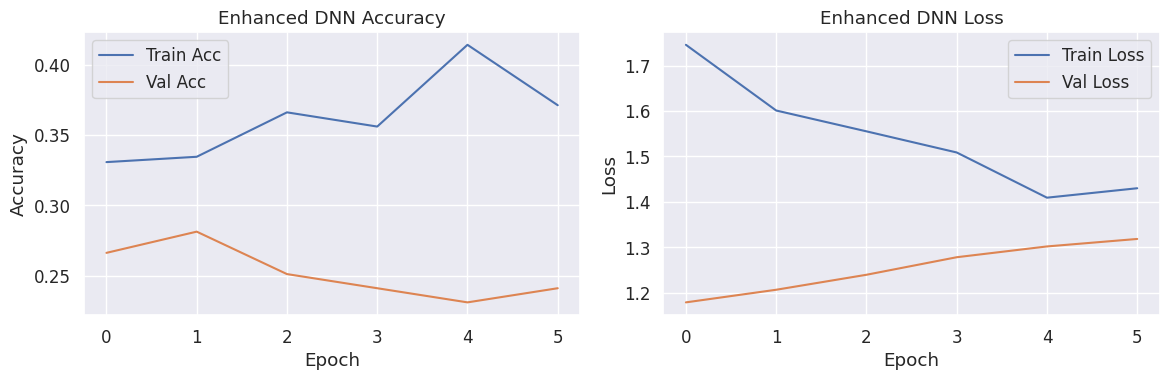

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Classification Report:
              precision    recall  f1-score   support

        High       0.20      0.28      0.23        36
         Low       0.25      0.45      0.32        62
      Medium       0.42      0.15      0.22       101

    accuracy                           0.27       199
   macro avg       0.29      0.29      0.26       199
weighted avg       0.32      0.27      0.25       199



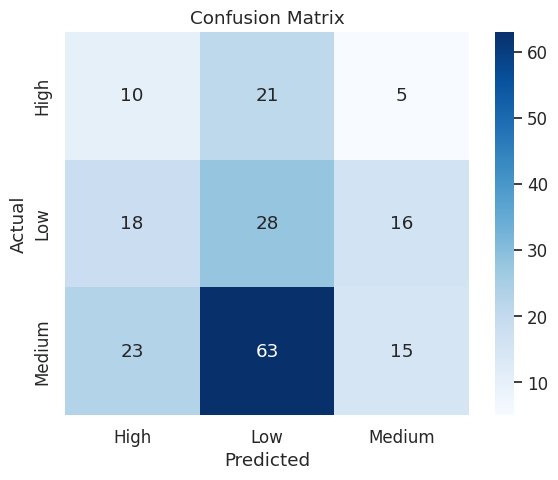

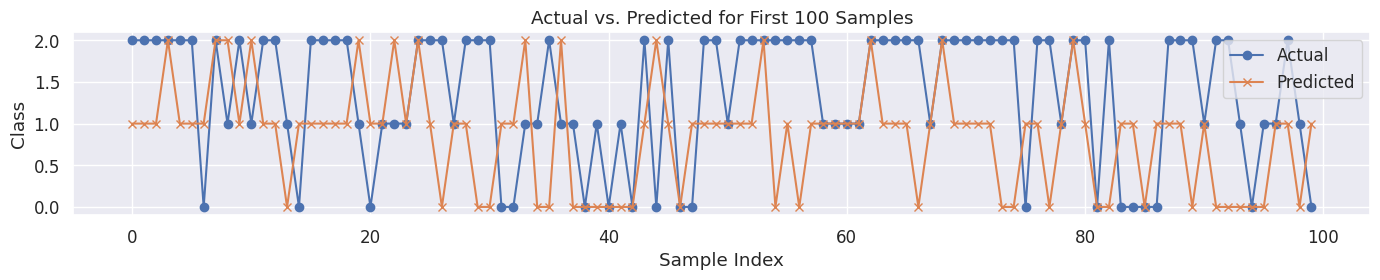


💾 Model saved to enhanced_dnn_ghi_classifier.keras


In [ ]:
# ============================================================
# Cell 9a: Final Enhanced DNN for GHI Category Classification
# Purpose: Mirrors your emotion-detection notebook’s structure
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

print("✅ TensorFlow version:", tf.__version__)

# ── 0. Prepare Data ──────────────────────────────────────────────
# We assume X_tr, X_te (3D windows) and y_tr, y_te (integer labels) come from Cell 7.

# Flatten sliding windows for DNN input
timesteps = X_tr.shape[1]
n_feats   = X_tr.shape[2]
X_train_dnn = X_tr.reshape(-1, timesteps * n_feats)
X_test_dnn  = X_te.reshape(-1, timesteps * n_feats)

# One-hot encode labels
num_classes  = len(np.unique(y_tr))
y_train_cat  = to_categorical(y_tr, num_classes)
y_test_cat   = to_categorical(y_te, num_classes)

# Compute class weights to address imbalance
classes      = np.unique(y_tr)
cw           = compute_class_weight('balanced', classes=classes, y=y_tr)
class_weight = dict(zip(classes, cw))

# ── 1. Build Enhanced DNN ─────────────────────────────────────────
model = Sequential([
    Dense(512, activation='relu', input_shape=(timesteps * n_feats,)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# ── 2. Train Model ──────────────────────────────────────────────
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

start_time = time.time()
history = model.fit(
    X_train_dnn, y_train_cat,
    validation_data=(X_test_dnn, y_test_cat),
    epochs=50,
    batch_size=32,
    class_weight=class_weight,
    callbacks=[early_stop, reduce_lr],
    verbose=2
)
print(f"\n⏱ Training time: {time.time() - start_time:.1f}s")

# ── 3. Evaluate on Test Set ─────────────────────────────────────
test_loss, test_acc = model.evaluate(X_test_dnn, y_test_cat, verbose=0)
print(f"\n📊 Test Accuracy: {test_acc:.4f}")
print(f"📊 Test Loss: {test_loss:.4f}")

# ── 4. Training Curves ──────────────────────────────────────────
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Enhanced DNN Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Enhanced DNN Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

# ── 5. Predictions and Classification Report ────────────────────
y_pred_probs   = model.predict(X_test_dnn)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_te, y_pred_classes, target_names=label_encoder.classes_))

# ── 6. Confusion Matrix ──────────────────────────────────────────
cm = confusion_matrix(y_te, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ── 7. Predictions Plot ─────────────────────────────────────────
plt.figure(figsize=(14, 3))
plt.plot(y_te[:100], 'o-', label='Actual')
plt.plot(y_pred_classes[:100], 'x-', label='Predicted')
plt.title('Actual vs. Predicted for First 100 Samples')
plt.xlabel('Sample Index'); plt.ylabel('Class')
plt.legend()
plt.tight_layout()
plt.show()

# ── 8. Save Model ───────────────────────────────────────────────
model_path = 'enhanced_dnn_ghi_classifier.keras'
model.save(model_path)
print(f"\n💾 Model saved to {model_path}")


## DNN BASELINE

✅ TensorFlow version: 2.18.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,971 (15.51 KB)

 Trainable params: 3,971 (15.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3977 - loss: 1.1516 - val_accuracy: 0.4750 - val_loss: 1.1337
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5090 - loss: 1.0040 - val_accuracy: 0.4550 - val_loss: 1.0798
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5236 - loss: 0.9841 - val_accuracy: 0.4650 - val_loss: 1.0818
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5360 - loss: 0.9639 - val_accuracy: 0.4700 - val_loss: 1.0731
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5562 - loss: 0.9608 - val_accuracy: 0.4600 - val_loss: 1.0697
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5777 - loss: 0.9230 - val_accuracy: 0.4600 - val_loss: 1.0738
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5436 - loss: 0.9390 - val_accuracy: 0.4450 - val_loss: 1.0688
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5649 - loss: 0.9227 - val_accuracy: 0.4650 - val_loss

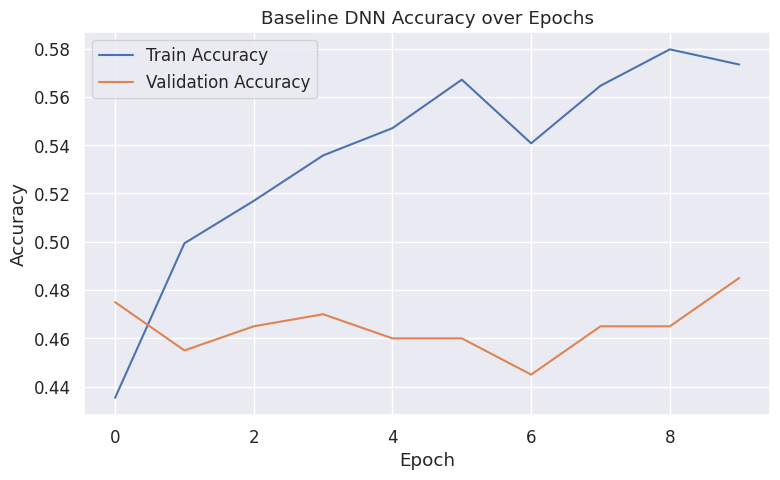

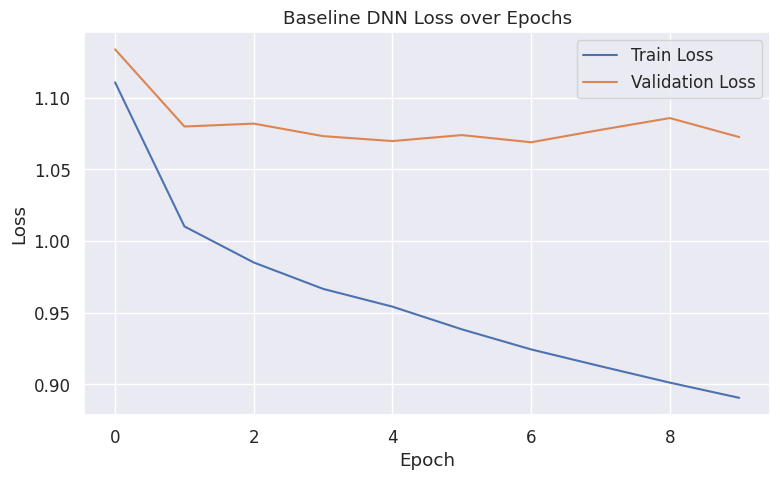

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Classification Report (Baseline DNN):
              precision    recall  f1-score   support

        High       0.33      0.03      0.05        36
         Low       0.11      0.03      0.05        62
      Medium       0.48      0.84      0.61       102

    accuracy                           0.45       200
   macro avg       0.31      0.30      0.24       200
weighted avg       0.34      0.45      0.34       200



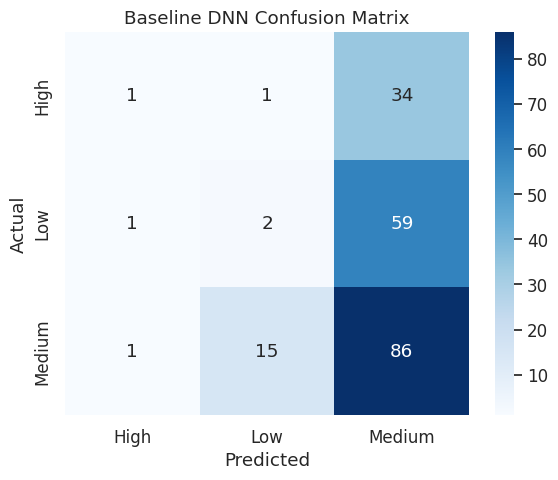


💾 Baseline DNN saved to baseline_dnn_ghi_classifier.keras


In [ ]:
# ============================================================
# Cell 9a: Baseline Dense Neural Network (DNN)
# Purpose: Simple baseline classifier for GHI Category
# ============================================================

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

print("✅ TensorFlow version:", tf.__version__)

# ── 0. Prepare Data ──────────────────────────────────────────────
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat  = to_categorical(y_test,  num_classes=num_classes)

input_dim = X_train.shape[1]

# ── 1. Build Baseline Model ─────────────────────────────────────
baseline_dnn = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),  # 1st Dense
    Dense(32, activation='relu'),                            # 2nd Dense
    Dense(num_classes, activation='softmax')                 # Output
])

baseline_dnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

baseline_dnn.summary()

# ── 2. Train Model ──────────────────────────────────────────────
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = baseline_dnn.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=15,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

# ── 3. Evaluate on Test Set ─────────────────────────────────────
test_loss, test_acc = baseline_dnn.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n📊 Baseline DNN Test Accuracy: {test_acc:.4f}")
print(f"📊 Baseline DNN Test Loss: {test_loss:.4f}")

# ── 4. Training Curves ──────────────────────────────────────────
# Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline DNN Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Baseline DNN Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ── 5. Predictions and Classification Report ────────────────────
y_pred_probs = baseline_dnn.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report (Baseline DNN):")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
cm_dnn = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_dnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Baseline DNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ── 6. Save Model ───────────────────────────────────────────────
dnn_model_path = 'baseline_dnn_ghi_classifier.keras'
baseline_dnn.save(dnn_model_path)
print(f"\n💾 Baseline DNN saved to {dnn_model_path}")


## DNN OPTIMIZED

[I 2025-08-01 00:50:37,678] A new study created in memory with name: no-name-2f41a76a-a7e0-4f07-8dd7-6ed9df645e6d


✅ Sliding Window Prepared: (794, 104), Target Shape: (794,)
Class Weights: {0: 2.0677083333333335, 1: 1.0338541666666667, 2: 0.6455284552845528}
🔍 Running Optuna hyperparameter tuning...


[I 2025-08-01 00:50:54,796] Trial 0 finished with value: 0.4833333194255829 and parameters: {'units1': 126, 'units2': 102, 'units3': 45, 'dropout1': 0.20518582139837893, 'dropout2': 0.35084575161903253, 'dropout3': 0.22218024569946504, 'lr': 0.0005927966200644483, 'batch_size': 32}. Best is trial 0 with value: 0.4833333194255829.
[I 2025-08-01 00:51:09,004] Trial 1 finished with value: 0.32499998807907104 and parameters: {'units1': 140, 'units2': 119, 'units3': 37, 'dropout1': 0.49413168994072987, 'dropout2': 0.3104513450614433, 'dropout3': 0.2553177527805268, 'lr': 0.0004026755769232893, 'batch_size': 128}. Best is trial 0 with value: 0.4833333194255829.
[I 2025-08-01 00:51:18,185] Trial 2 finished with value: 0.4749999940395355 and parameters: {'units1': 87, 'units2': 41, 'units3': 23, 'dropout1': 0.49503797548667194, 'dropout2': 0.4838310829205645, 'dropout3': 0.12388460762568188, 'lr': 0.0035664742167880615, 'batch_size': 32}. Best is trial 0 with value: 0.4833333194255829.
[I 2025

🏆 Best Trial Params: {'units1': 209, 'units2': 45, 'units3': 17, 'dropout1': 0.22239618617022303, 'dropout2': 0.46311343842007363, 'dropout3': 0.3401917875465875, 'lr': 0.003908214295460966, 'batch_size': 128}
Best Validation Accuracy: 0.5417
▶ Training Final Optimized DNN...
Epoch 1/60
6/6 - 4s - 603ms/step - accuracy: 0.3249 - loss: 1.5437 - val_accuracy: 0.3833 - val_loss: 1.0514 - learning_rate: 0.0039
Epoch 2/60
6/6 - 0s - 63ms/step - accuracy: 0.3947 - loss: 1.3056 - val_accuracy: 0.4333 - val_loss: 1.0488 - learning_rate: 0.0039
Epoch 3/60
6/6 - 0s - 56ms/step - accuracy: 0.4080 - loss: 1.2082 - val_accuracy: 0.4000 - val_loss: 1.0586 - learning_rate: 0.0039
Epoch 4/60
6/6 - 0s - 52ms/step - accuracy: 0.4228 - loss: 1.1404 - val_accuracy: 0.4500 - val_loss: 1.0698 - learning_rate: 0.0039
Epoch 5/60
6/6 - 1s - 123ms/step - accuracy: 0.4585 - loss: 1.0993 - val_accuracy: 0.4167 - val_loss: 1.0799 - learning_rate: 0.0039
Epoch 6/60
6/6 - 1s - 89ms/step - accuracy: 0.4050 - loss: 1.

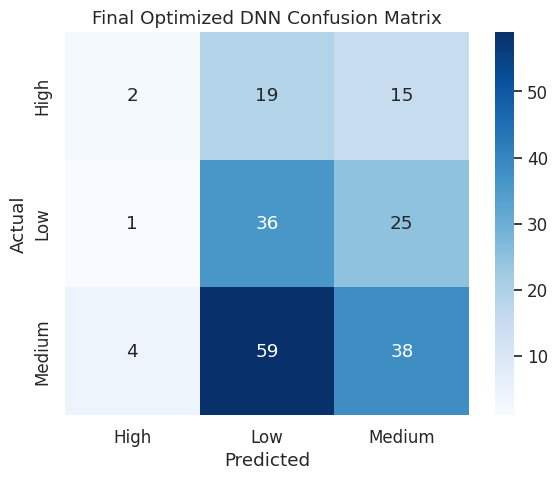

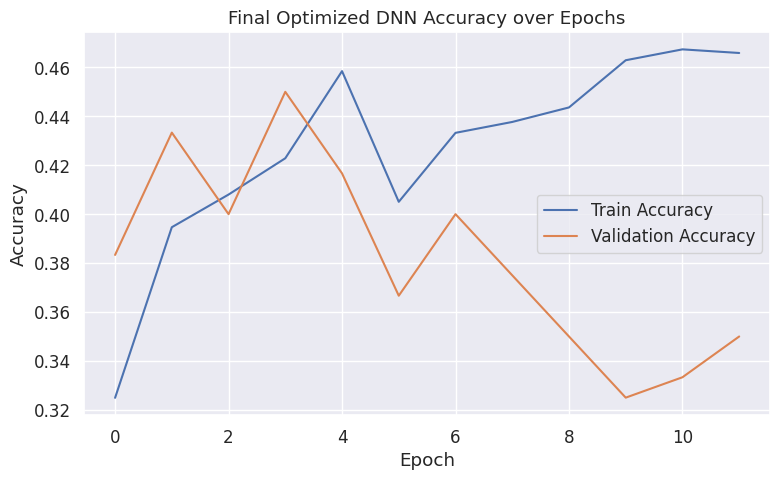

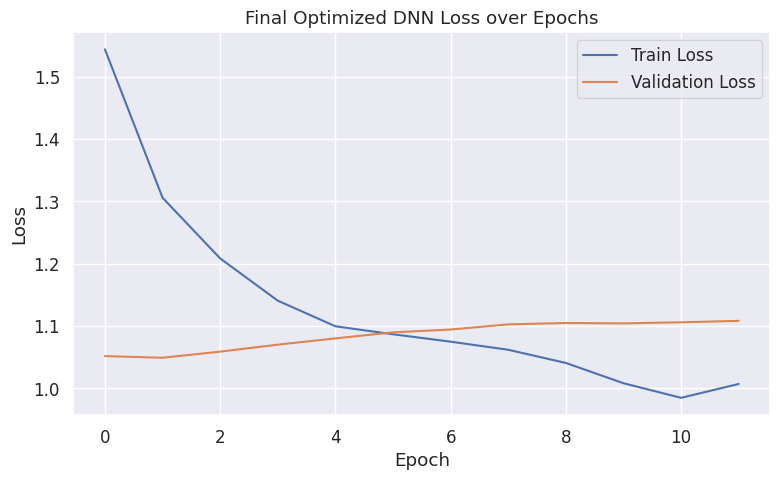


📊 Running SHAP Analysis...


PermutationExplainer explainer: 200it [00:55,  3.45it/s]
/tmp/ipython-input-4190327135.py:186: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_te_seq[:200], feature_names=feature_names, show=True)


Top 10 Features by SHAP:
         Feature  Mean |SHAP|
76    Feature_76     0.018021
242  Feature_242     0.014782
256  Feature_256     0.014714
77    Feature_77     0.013909
238  Feature_238     0.012964
257  Feature_257     0.012455
29    Feature_29     0.012429
43    Feature_43     0.011531
220  Feature_220     0.011522
112  Feature_112     0.011395


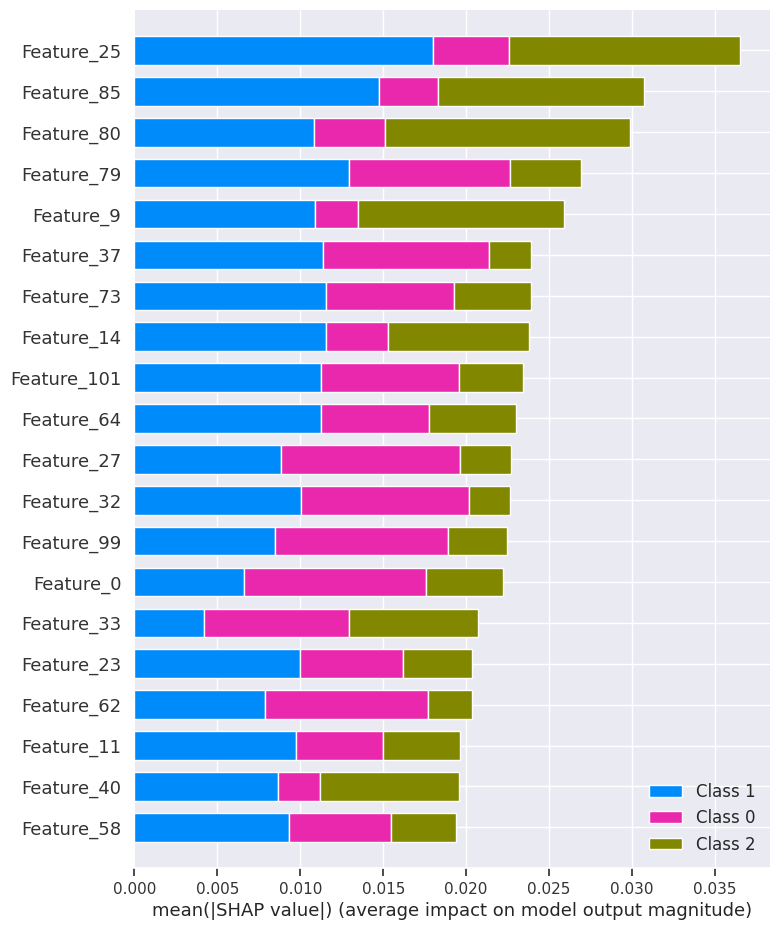

✅ Saved Final Optimized DNN model to 'final_optimized_dnn_timeaware.keras'


In [ ]:
# ============================================================
# Cell 9b: Advanced Optimized Dense Neural Network (Final)
# with Sliding Window + Optuna Hyperparameter Tuning + SHAP
# ============================================================

import optuna
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import shap
import pandas as pd

# 1. Ensure numeric features only
X_num = X_final.select_dtypes(include=[np.number]).copy().astype('float32')

# 2. Sliding Window Feature Creation
def create_sliding_window(X, y, timesteps=4):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X.iloc[i-timesteps:i].values.flatten())
        y_seq.append(y[i])
    return np.array(X_seq, dtype='float32'), np.array(y_seq, dtype='int32')

timesteps = 4  # past 2 hours (4 × 30 min)
X_seq, y_seq = create_sliding_window(X_num, y_final, timesteps)

# Chronological split
train_size = int(0.8 * len(X_seq))
X_tr_seq, X_te_seq = X_seq[:train_size], X_seq[train_size:]
y_tr_seq, y_te_seq = y_seq[:train_size], y_seq[train_size:]
print(f"✅ Sliding Window Prepared: {X_tr_seq.shape}, Target Shape: {y_tr_seq.shape}")

# 3. Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_tr_seq), y=y_tr_seq)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# 4. Define Optuna Objective
def objective(trial):
    model = Sequential(name='Optuna_Tuned_DNN')
    n_units1 = trial.suggest_int('units1', 64, 256)
    n_units2 = trial.suggest_int('units2', 32, 128)
    n_units3 = trial.suggest_int('units3', 16, 64)
    dropout1 = trial.suggest_float('dropout1', 0.2, 0.5)
    dropout2 = trial.suggest_float('dropout2', 0.2, 0.5)
    dropout3 = trial.suggest_float('dropout3', 0.1, 0.4)
    lr = trial.suggest_float('lr', 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    model.add(Dense(n_units1, activation='relu', kernel_regularizer=l2(1e-4),
                    input_shape=(X_tr_seq.shape[1],)))
    model.add(BatchNormalization()); model.add(Dropout(dropout1))
    model.add(Dense(n_units2, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization()); model.add(Dropout(dropout2))
    model.add(Dense(n_units3, activation='relu', kernel_regularizer=l2(1e-4)))
    model.add(BatchNormalization()); model.add(Dropout(dropout3))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_tr_seq, y_tr_seq,
        validation_split=0.15,
        epochs=30,
        batch_size=batch_size,
        class_weight=class_weight_dict,
        verbose=0,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        ]
    )
    return max(history.history['val_accuracy'])

# 5. Run Optuna
print("🔍 Running Optuna hyperparameter tuning...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)
print("🏆 Best Trial Params:", study.best_trial.params)
print(f"Best Validation Accuracy: {study.best_value:.4f}")

# 6. Train Final Model with Best Params
best_params = study.best_params
final_dnn = Sequential(name='Final_Optimized_DNN')

final_dnn.add(Dense(best_params['units1'], activation='relu', kernel_regularizer=l2(1e-4),
                    input_shape=(X_tr_seq.shape[1],)))
final_dnn.add(BatchNormalization()); final_dnn.add(Dropout(best_params['dropout1']))
final_dnn.add(Dense(best_params['units2'], activation='relu', kernel_regularizer=l2(1e-4)))
final_dnn.add(BatchNormalization()); final_dnn.add(Dropout(best_params['dropout2']))
final_dnn.add(Dense(best_params['units3'], activation='relu', kernel_regularizer=l2(1e-4)))
final_dnn.add(BatchNormalization()); final_dnn.add(Dropout(best_params['dropout3']))
final_dnn.add(Dense(len(label_encoder.classes_), activation='softmax'))

final_dnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['lr']),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("▶ Training Final Optimized DNN...")
history_final = final_dnn.fit(
    X_tr_seq, y_tr_seq,
    validation_split=0.15,
    epochs=60,
    batch_size=best_params['batch_size'],
    class_weight=class_weight_dict,
    verbose=2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
    ]
)

# 7. Evaluate Model
y_pred_probs = final_dnn.predict(X_te_seq)
y_pred = np.argmax(y_pred_probs, axis=1)

acc_final = accuracy_score(y_te_seq, y_pred)
f1_final  = f1_score(y_te_seq, y_pred, average='weighted')
print(f"Final Optimized DNN Accuracy:     {acc_final:.4f}")
print(f"Final Optimized DNN Weighted F1:  {f1_final:.4f}\n")
print("Classification Report:")
print(classification_report(y_te_seq, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_te_seq, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Final Optimized DNN Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# 8. Training Curves
plt.figure(figsize=(8,5))
plt.plot(history_final.history['accuracy'], label='Train Accuracy')
plt.plot(history_final.history['val_accuracy'], label='Validation Accuracy')
plt.title('Final Optimized DNN Accuracy over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Final Optimized DNN Loss over Epochs')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# 9. SHAP Analysis
print("\n📊 Running SHAP Analysis...")
explainer = shap.Explainer(final_dnn, X_te_seq[:200])
shap_values = explainer(X_te_seq[:200])

shap_mean = np.abs(shap_values.values).mean(axis=0).flatten()

# Generate feature names dynamically
feature_names = []
for t in range(timesteps, 0, -1):
    for col in X_num.columns:
        feature_names.append(f"{col}_t-{t}")

if len(shap_mean) != len(feature_names):
    feature_names = [f"Feature_{i}" for i in range(len(shap_mean))]

shap_importance = pd.DataFrame({
    "Feature": feature_names,
    "Mean |SHAP|": shap_mean
}).sort_values("Mean |SHAP|", ascending=False)

print("Top 10 Features by SHAP:")
print(shap_importance.head(10))

shap.summary_plot(shap_values, X_te_seq[:200], feature_names=feature_names, show=True)

# 10. Save Final Model
final_dnn.save('final_optimized_dnn_timeaware.keras')
print("✅ Saved Final Optimized DNN model to 'final_optimized_dnn_timeaware.keras'")



# LSTM Baseline LSTM (32 units, 10 epochs)

✅ Data reshaped for LSTM: (797, 1, 26), (200, 1, 26)


Model: "Baseline_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ InputSeq (InputLayer)           │ (None, 1, 26)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM32 (LSTM)                   │ (None, 32)             │         7,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,651 (29.89 KB)

 Trainable params: 7,651 (29.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
23/23 - 5s - 229ms/step - accuracy: 0.3250 - loss: 1.1175 - val_accuracy: 0.3125 - val_loss: 1.0564
Epoch 2/10
23/23 - 1s - 25ms/step - accuracy: 0.3250 - loss: 1.0587 - val_accuracy: 0.3125 - val_loss: 0.9993
Epoch 3/10
23/23 - 1s - 29ms/step - accuracy: 0.4073 - loss: 1.0304 - val_accuracy: 0.5750 - val_loss: 0.9712
Epoch 4/10
23/23 - 1s - 54ms/step - accuracy: 0.5091 - loss: 1.0165 - val_accuracy: 0.5750 - val_loss: 0.9563
Epoch 5/10
23/23 - 1s - 49ms/step - accuracy: 0.5091 - loss: 1.0104 - val_accuracy: 0.5750 - val_loss: 0.9492
Epoch 6/10
23/23 - 1s - 25ms/step - accuracy: 0.5091 - loss: 1.0083 - val_accuracy: 0.5750 - val_loss: 0.9452
Epoch 7/10
23/23 - 1s - 22ms/step - accuracy: 0.5091 - loss: 1.0075 - val_accuracy: 0.5750 - val_loss: 0.9433
Epoch 8/10
23/23 - 0s - 7ms/step - accuracy: 0.5091 - loss: 1.0074 - val_accuracy: 0.5750 - val_loss: 0.9418
Epoch 9/10
23/23 - 0s - 12ms/step - accuracy: 0.5091 - loss: 1.0075 - val_accuracy: 0.5750 - val_loss: 0.9425
Epoch 10/1

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Baseline LSTM Accuracy:    0.5100
Baseline LSTM Weighted F1: 0.3445

Baseline LSTM Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        36
         Low       0.00      0.00      0.00        62
      Medium       0.51      1.00      0.68       102

    accuracy                           0.51       200
   macro avg       0.17      0.33      0.23       200
weighted avg       0.26      0.51      0.34       200



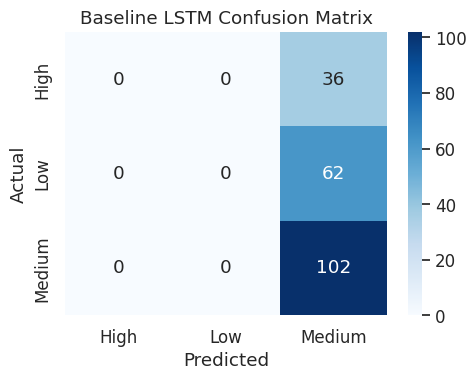

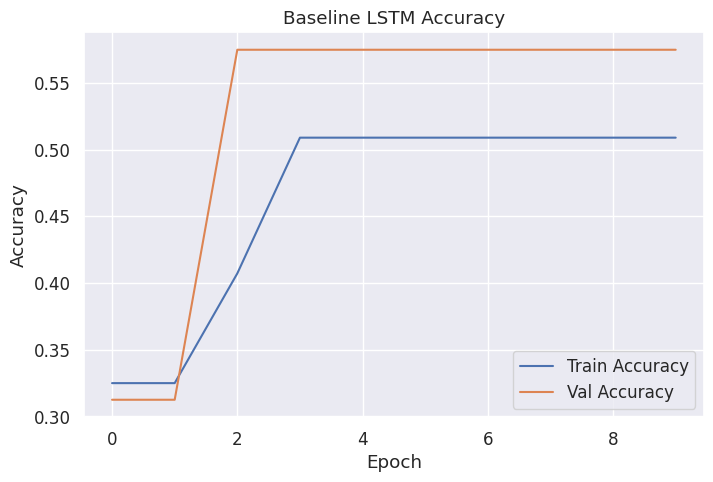

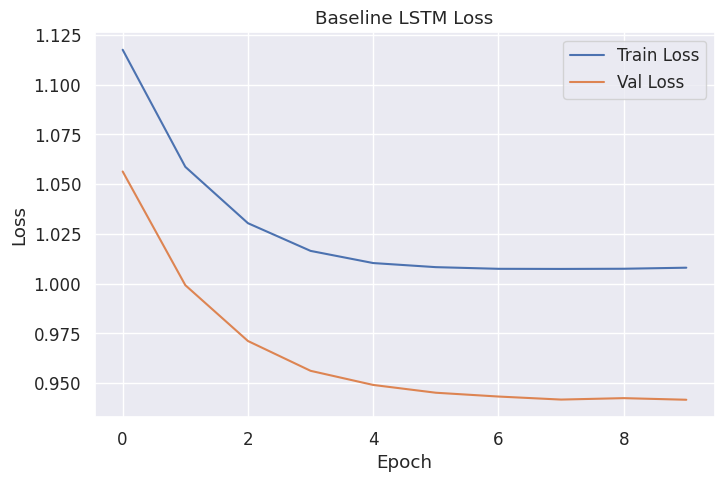

🔹 Saved Baseline LSTM model to 'baseline_lstm_ghi_classifier.keras'


In [ ]:
# ============================================================
# Cell 10a: Baseline LSTM (Fixed Column Mismatch)
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ---- 1. Ensure same feature set as scaler ----
# If you saved numeric_cols earlier:
if "numeric_cols" in globals():
    X_tr_aligned = X_train[numeric_cols]
    X_te_aligned = X_test[numeric_cols]
else:
    # fallback: drop non-numeric
    X_tr_aligned = X_train.select_dtypes(include=[np.number])
    X_te_aligned = X_test.select_dtypes(include=[np.number])

X_tr_scaled = scaler.transform(X_tr_aligned)
X_te_scaled = scaler.transform(X_te_aligned)

y_tr = np.array(y_train, dtype=int)
y_te = np.array(y_test, dtype=int)

timesteps  = 1
n_features = X_tr_scaled.shape[1]

X_tr_seq   = X_tr_scaled.reshape((-1, timesteps, n_features))
X_te_seq   = X_te_scaled.reshape((-1, timesteps, n_features))

print(f"✅ Data reshaped for LSTM: {X_tr_seq.shape}, {X_te_seq.shape}")

# ---- 2. Build baseline LSTM ----
inputs = Input(shape=(timesteps, n_features), name='InputSeq')
x = LSTM(32, name='LSTM32')(inputs)
outputs = Dense(len(label_encoder.classes_), activation='softmax')(x)

baseline_lstm = Model(inputs, outputs, name='Baseline_LSTM')
baseline_lstm.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
baseline_lstm.summary()

# ---- 3. Train baseline LSTM ----
start = time.time()
history_lstm_base = baseline_lstm.fit(
    X_tr_seq, y_tr,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=2
)
print(f"\n🔹 Baseline LSTM trained in {time.time() - start:.2f}s")

# ---- 4. Evaluate baseline LSTM ----
y_pred_lstm_base = np.argmax(baseline_lstm.predict(X_te_seq), axis=1)
acc_lstm_base = accuracy_score(y_te, y_pred_lstm_base)
f1_lstm_base = f1_score(y_te, y_pred_lstm_base, average='weighted')

print(f"Baseline LSTM Accuracy:    {acc_lstm_base:.4f}")
print(f"Baseline LSTM Weighted F1: {f1_lstm_base:.4f}\n")
print("Baseline LSTM Classification Report:")
print(classification_report(y_te, y_pred_lstm_base, target_names=label_encoder.classes_))

# ---- 5. Confusion Matrix ----
cm_lstm_base = confusion_matrix(y_te, y_pred_lstm_base)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lstm_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Baseline LSTM Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ---- 6. Accuracy & Loss Plots ----
plt.figure(figsize=(8,5))
plt.plot(history_lstm_base.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm_base.history['val_accuracy'], label='Val Accuracy')
plt.title('Baseline LSTM Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
plt.plot(history_lstm_base.history['loss'], label='Train Loss')
plt.plot(history_lstm_base.history['val_loss'], label='Val Loss')
plt.title('Baseline LSTM Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True); plt.show()

# ---- 7. Save baseline LSTM ----
baseline_lstm.save('baseline_lstm_ghi_classifier.keras')
print("🔹 Saved Baseline LSTM model to 'baseline_lstm_ghi_classifier.keras'")


## LSTM OPTIMIZED

✅ Optimized LSTM data prepared: (797, 1, 26), (200, 1, 26)


Model: "Optimized_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Sequence (InputLayer)     │ (None, 1, 26)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer (LSTM)               │ (None, 64)             │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm (BatchNormalization)  │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,731 (100.51 KB)

 Trainable params: 25,603 (100.01 KB)

 Non-trainable params: 128 (512.00 B)

▶ Training Optimized LSTM…
Epoch 1/60
23/23 - 12s - 529ms/step - accuracy: 0.4045 - loss: 1.2222 - val_accuracy: 0.3125 - val_loss: 1.0550 - learning_rate: 0.0010
Epoch 2/60
23/23 - 3s - 115ms/step - accuracy: 0.4435 - loss: 1.1469 - val_accuracy: 0.5750 - val_loss: 0.9913 - learning_rate: 0.0010
Epoch 3/60
23/23 - 1s - 28ms/step - accuracy: 0.4491 - loss: 1.1360 - val_accuracy: 0.5750 - val_loss: 0.9981 - learning_rate: 0.0010
Epoch 4/60
23/23 - 0s - 17ms/step - accuracy: 0.4672 - loss: 1.1069 - val_accuracy: 0.3125 - val_loss: 0.9964 - learning_rate: 0.0010
Epoch 5/60
23/23 - 0s - 14ms/step - accuracy: 0.4463 - loss: 1.0955 - val_accuracy: 0.5750 - val_loss: 0.9562 - learning_rate: 0.0010
Epoch 6/60
23/23 - 0s - 16ms/step - accuracy: 0.4491 - loss: 1.1122 - val_accuracy: 0.5750 - val_loss: 1.0006 - learning_rate: 0.0010
Epoch 7/60
23/23 - 1s - 24ms/step - accuracy: 0.4616 - loss: 1.0837 - val_accuracy: 0.5750 - val_loss: 0.9547 - learning_rate: 0.0010
Epoch 8/60
23/23 - 1s - 22ms/ste

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
Optimized LSTM Accuracy:     0.5100
Optimized LSTM Weighted F1:  0.3445

Optimized LSTM Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        36
         Low       0.00      0.00      0.00        62
      Medium       0.51      1.00      0.68       102

    accuracy                           0.51       200
   macro avg       0.17      0.33      0.23       200
weighted avg       0.26      0.51      0.34       200



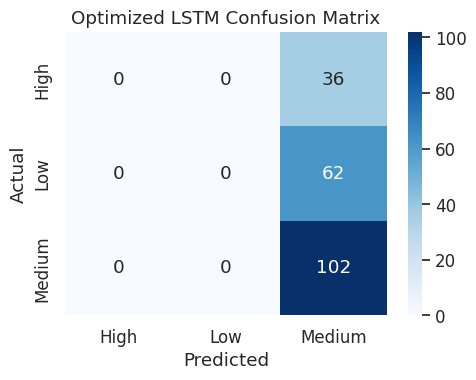

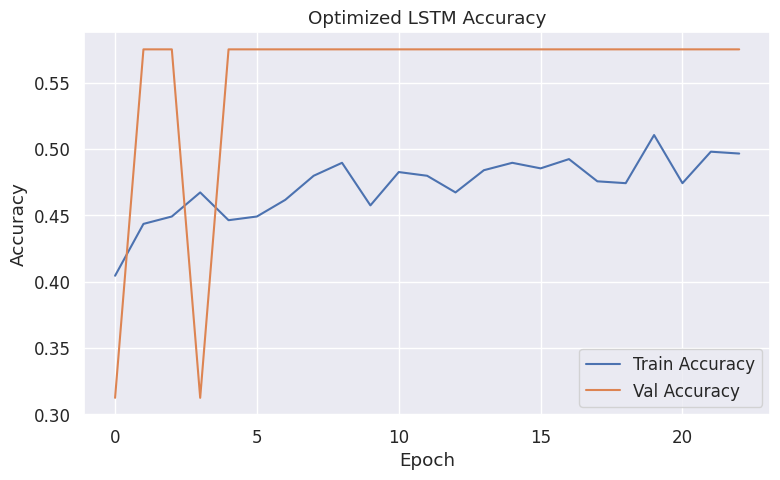

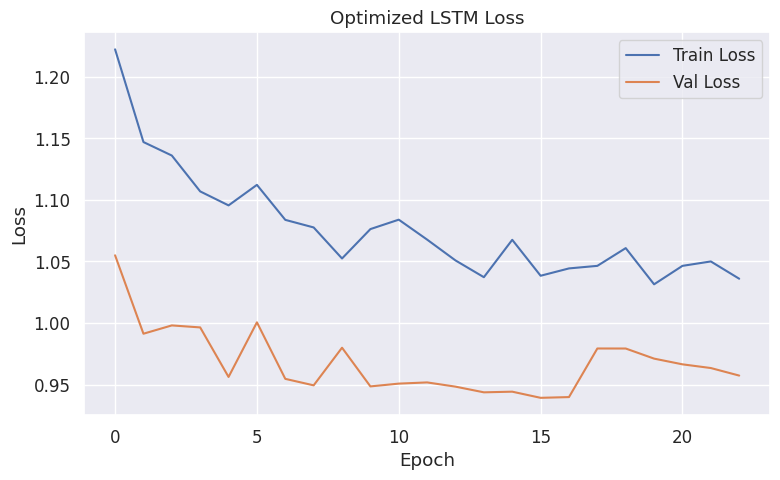

✅ Saved Optimized LSTM model to 'optimized_lstm_ghi_classifier.keras'


In [ ]:
# ============================================================
# Cell 10b: Optimized LSTM – Training + Evaluation + Plots
# ============================================================

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ---- 1. Align features with scaler ----
if "numeric_cols" in globals():
    X_tr_aligned = X_train[numeric_cols]
    X_te_aligned = X_test[numeric_cols]
else:
    X_tr_aligned = X_train.select_dtypes(include=[np.number])
    X_te_aligned = X_test.select_dtypes(include=[np.number])

X_tr_np = scaler.transform(X_tr_aligned).astype('float32')
X_te_np = scaler.transform(X_te_aligned).astype('float32')
y_tr = np.array(y_train, dtype=int)
y_te = np.array(y_test, dtype=int)

# ---- 2. Reshape for LSTM ----
timesteps  = 1
n_features = X_tr_np.shape[1]
X_tr_seq   = X_tr_np.reshape(-1, timesteps, n_features)
X_te_seq   = X_te_np.reshape(-1, timesteps, n_features)

print(f"✅ Optimized LSTM data prepared: {X_tr_seq.shape}, {X_te_seq.shape}")

# ---- 3. Build optimized LSTM ----
inputs = Input(shape=(timesteps, n_features), name='Input_Sequence')
x = LSTM(
    64,
    kernel_regularizer=l2(1e-4),
    recurrent_regularizer=l2(1e-4),
    dropout=0.2,
    recurrent_dropout=0.2,
    name='LSTM_Layer'
)(inputs)
x = BatchNormalization(name='BatchNorm')(x)
x = Dense(32, activation='relu', name='Dense_1')(x)
x = Dropout(0.3, name='Dropout')(x)
outputs = Dense(len(label_encoder.classes_), activation='softmax', name='Output')(x)

opt_lstm = Model(inputs, outputs, name='Optimized_LSTM')
opt_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
opt_lstm.summary()

# ---- 4. Train with callbacks ----
print("▶ Training Optimized LSTM…")
start = time.time()
history_lstm = opt_lstm.fit(
    X_tr_seq, y_tr,
    validation_split=0.1,
    epochs=60,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)
    ],
    verbose=2
)
train_time = time.time() - start
print(f"✔ Optimized LSTM trained in {train_time:.2f}s")

# ---- 5. Evaluate optimized LSTM ----
y_pred_lstm = np.argmax(opt_lstm.predict(X_te_seq), axis=1)
acc_lstm    = accuracy_score(y_te, y_pred_lstm)
f1_lstm     = f1_score(y_te, y_pred_lstm, average='weighted')

print(f"Optimized LSTM Accuracy:     {acc_lstm:.4f}")
print(f"Optimized LSTM Weighted F1:  {f1_lstm:.4f}\n")
print("Optimized LSTM Classification Report:")
print(classification_report(y_te, y_pred_lstm, target_names=label_encoder.classes_))

# ---- 6. Confusion Matrix ----
cm_lstm = confusion_matrix(y_te, y_pred_lstm)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Optimized LSTM Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# ---- 7. Accuracy & Loss Plots ----
plt.figure(figsize=(8,5))
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
plt.title('Optimized LSTM Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Val Loss')
plt.title('Optimized LSTM Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

# ---- 8. Save optimized LSTM ----
opt_lstm.save('optimized_lstm_ghi_classifier.keras')
print("✅ Saved Optimized LSTM model to 'optimized_lstm_ghi_classifier.keras'")


✅ Feature list loaded from training.
✅ Using scaler's feature_names_in_ for alignment.

📊 Random Forest Evaluation:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        36
         Low       0.38      0.16      0.23        62
      Medium       0.51      0.84      0.63       102

    accuracy                           0.48       200
   macro avg       0.30      0.33      0.29       200
weighted avg       0.38      0.48      0.39       200



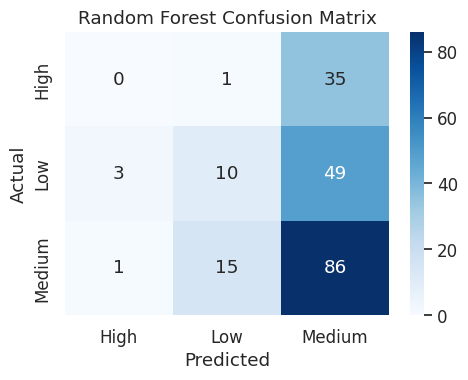


📊 XGBoost Evaluation:
              precision    recall  f1-score   support

        High       0.17      0.11      0.13        36
         Low       0.33      0.34      0.34        62
      Medium       0.49      0.54      0.51       102

    accuracy                           0.40       200
   macro avg       0.33      0.33      0.33       200
weighted avg       0.38      0.40      0.39       200



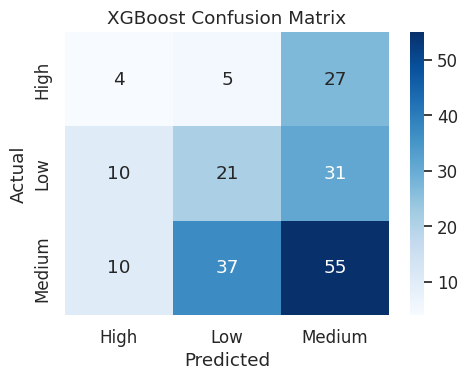


📊 LSTM Evaluation:
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        36
         Low       0.00      0.00      0.00        62
      Medium       0.51      1.00      0.68       102

    accuracy                           0.51       200
   macro avg       0.17      0.33      0.23       200
weighted avg       0.26      0.51      0.34       200



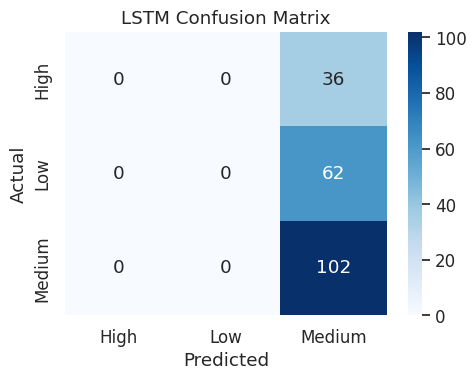


✅ Summary of Model Performance:


,Accuracy,F1
Random Forest,0.48,0.3930
XGBoost,0.40,0.3891
LSTM,0.51,0.3445


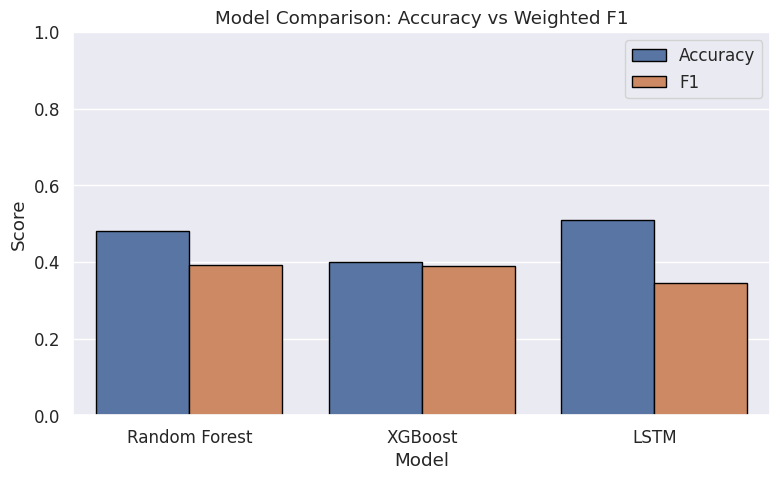

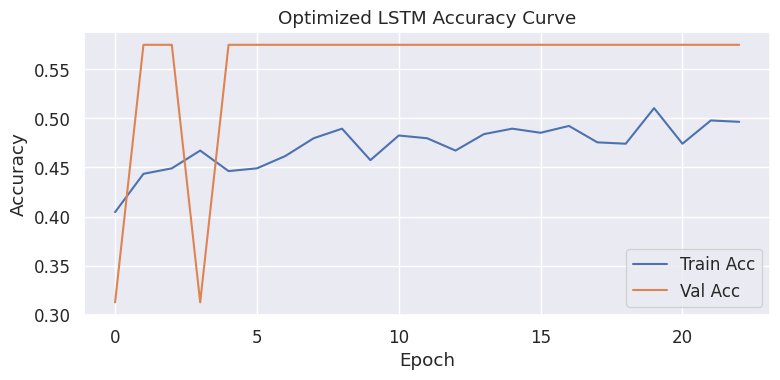

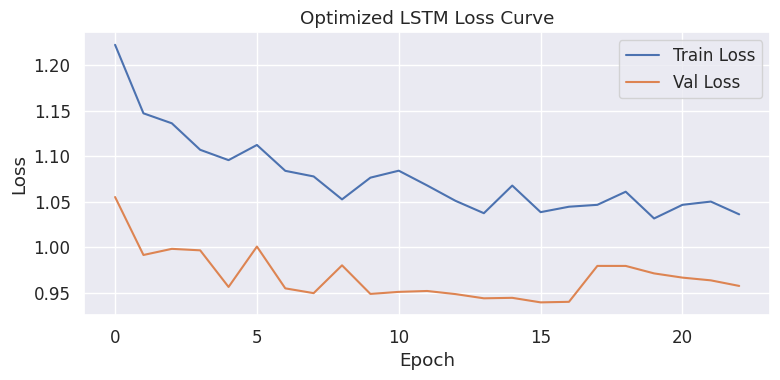

In [ ]:
# ============================================================
# Cell 11: Model Evaluation & Comparison with Visualizations
# ============================================================

import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import tensorflow as tf

sns.set_context("notebook", font_scale=1.1)

# ---- 1. Load models & artifacts safely ----
def safe_load_joblib(path):
    try:
        return joblib.load(path)
    except Exception as e:
        print(f"⚠️ Could not load {path}: {e}")
        return None

def safe_load_keras(path):
    try:
        return tf.keras.models.load_model(path)
    except Exception as e:
        print(f"⚠️ Could not load {path}: {e}")
        return None

rf = safe_load_joblib('rf_model_ghi_class.pkl')
xgb = safe_load_joblib('xgb_advanced_model.pkl')
lstm = safe_load_keras('optimized_lstm_ghi_classifier.keras')
scaler = safe_load_joblib('scaler.pkl')
label_encoder = safe_load_joblib('label_encoder.pkl')

# Load feature list (used for reference, not necessarily for scaling)
try:
    with open('feature_list_xgb.json', 'r') as f:
        feature_list = json.load(f)
    print("✅ Feature list loaded from training.")
except Exception as e:
    feature_list = None
    print(f"⚠️ feature_list_xgb.json not found or unreadable: {e}")

# ---- 2. Determine scaler feature names to avoid mismatch ----
if scaler is None:
    raise RuntimeError("Scaler not loaded; cannot proceed.")

if hasattr(scaler, "feature_names_in_"):
    scaler_features = list(scaler.feature_names_in_)
    print("✅ Using scaler's feature_names_in_ for alignment.")
elif "numeric_cols" in globals():
    scaler_features = numeric_cols
    print("⚠️ scaler has no feature_names_in_, falling back to stored numeric_cols.")
else:
    scaler_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
    print("⚠️ Falling back to numeric columns from X_train.")

# ---- 3. Prepare test data for each model ----
# Base test targets
y_te = np.array(y_test, dtype=int)

# For tree models: align their expected features individually
def align_df(df, cols):
    return df.reindex(columns=cols, fill_value=0)

# For neural models: scale using correct columns
X_te_for_scaling = X_test.reindex(columns=scaler_features, fill_value=0)
X_te_scaled = scaler.transform(X_te_for_scaling).astype("float32")
X_te_seq = X_te_scaled.reshape(-1, 1, X_te_scaled.shape[1])  # for LSTM

# ---- 4. Evaluation per model ----
metrics = {}

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"{title} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Random Forest
if rf is not None:
    print("\n📊 Random Forest Evaluation:")
    # align with what RF was trained on
    if hasattr(rf, "feature_names_in_"):
        X_rf = align_df(X_test, rf.feature_names_in_)
    else:
        X_rf = align_df(X_test, scaler_features)
    y_pred_rf = rf.predict(X_rf)
    acc_rf = accuracy_score(y_te, y_pred_rf)
    f1_rf = f1_score(y_te, y_pred_rf, average='weighted')
    metrics["Random Forest"] = {"Accuracy": acc_rf, "F1": f1_rf}
    print(classification_report(y_te, y_pred_rf, target_names=label_encoder.classes_))
    plot_conf_matrix(y_te, y_pred_rf, "Random Forest")

# XGBoost
if xgb is not None:
    print("\n📊 XGBoost Evaluation:")
    if hasattr(xgb, "feature_names_in_"):
        X_xgb = align_df(X_test, xgb.feature_names_in_)
    else:
        X_xgb = align_df(X_test, scaler_features)
    y_pred_xgb = xgb.predict(X_xgb)
    acc_xgb = accuracy_score(y_te, y_pred_xgb)
    f1_xgb = f1_score(y_te, y_pred_xgb, average='weighted')
    metrics["XGBoost"] = {"Accuracy": acc_xgb, "F1": f1_xgb}
    print(classification_report(y_te, y_pred_xgb, target_names=label_encoder.classes_))
    plot_conf_matrix(y_te, y_pred_xgb, "XGBoost")

# LSTM
if lstm is not None:
    print("\n📊 LSTM Evaluation:")
    y_pred_lstm = np.argmax(lstm.predict(X_te_seq), axis=1)
    acc_lstm = accuracy_score(y_te, y_pred_lstm)
    f1_lstm = f1_score(y_te, y_pred_lstm, average='weighted')
    metrics["LSTM"] = {"Accuracy": acc_lstm, "F1": f1_lstm}
    print(classification_report(y_te, y_pred_lstm, target_names=label_encoder.classes_))
    plot_conf_matrix(y_te, y_pred_lstm, "LSTM")

# ---- 5. Summary table ----
print("\n✅ Summary of Model Performance:")
summary_df = pd.DataFrame(metrics).T
display(summary_df.round(4))

# ---- 6. Comparison grouped bar chart ----
if summary_df.shape[0] > 0:
    df_plot = summary_df.reset_index().melt(id_vars="index", value_vars=["Accuracy", "F1"],
                                           var_name="Metric", value_name="Score")
    df_plot.rename(columns={"index": "Model"}, inplace=True)

    plt.figure(figsize=(8,5))
    sns.barplot(data=df_plot, x="Model", y="Score", hue="Metric", edgecolor="black")
    plt.title("Model Comparison: Accuracy vs Weighted F1")
    plt.ylim(0, 1)
    plt.legend(title="")
    plt.ylabel("Score")
    plt.tight_layout()
    plt.show()

# ---- 7. Optional: plot LSTM training curves if history object exists ----
if 'history_lstm' in globals():
    hist = history_lstm.history
    plt.figure(figsize=(8,4))
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title("Optimized LSTM Accuracy Curve")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title("Optimized LSTM Loss Curve")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


## Time-Series Cross-Validation for Final Champion Model


🔁 Running TimeSeriesSplit (5 folds) CV on champion model: XGB

Fold 1: Accuracy=0.3554, Weighted F1=0.3489
              precision    recall  f1-score   support

        High       0.12      0.08      0.10        36
         Low       0.25      0.30      0.27        46
      Medium       0.49      0.50      0.50        84

    accuracy                           0.36       166
   macro avg       0.29      0.30      0.29       166
weighted avg       0.35      0.36      0.35       166

------------------------------------------------------------
Fold 2: Accuracy=0.3855, Weighted F1=0.3920
              precision    recall  f1-score   support

        High       0.19      0.37      0.25        27
         Low       0.37      0.24      0.29        59
      Medium       0.53      0.50      0.52        80

    accuracy                           0.39       166
   macro avg       0.36      0.37      0.35       166
weighted avg       0.42      0.39      0.39       166

--------------------------

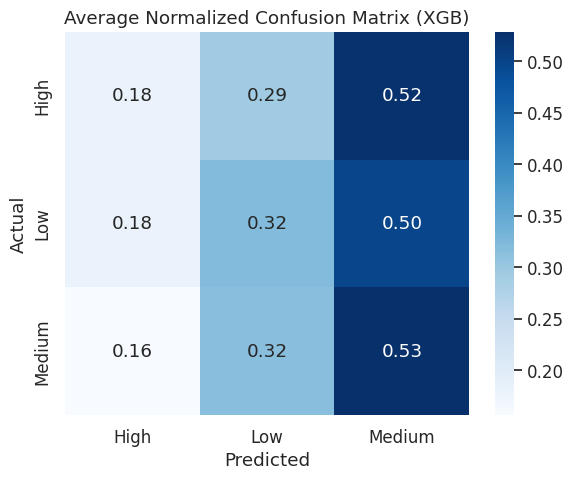

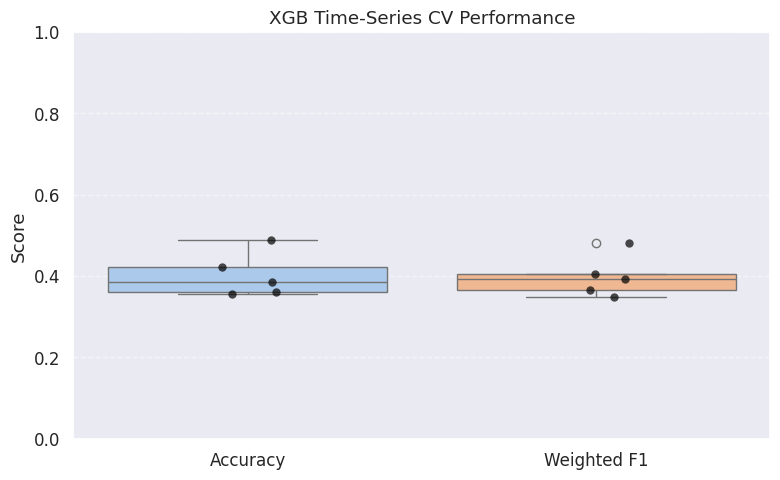

In [ ]:
# ============================================================
# Cell 12: Time-Series Cross-Validation for Final Champion Model
# (supports 'xgb' or 'rf'; handles Cloud_Type / non-numeric safely)
# ============================================================

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

sns.set_context("notebook", font_scale=1.1)

# -------- USER CHOICE: set champion model key to 'xgb' or 'rf' --------
champion_key = 'xgb'  # change to 'rf' if Random Forest is the champion

# -------- Prepare feature matrix and target --------
if 'X_final' not in globals() or 'y_final' not in globals():
    raise RuntimeError("X_final or y_final missing; run Feature Engineering cell to set them.")

# Work on a copy and drop original object columns that were not numeric (e.g., raw Cloud_Type)
X = X_final.copy()
# If raw categorical columns like 'Cloud_Type' exist, drop them; keep encoded versions
for col in X.select_dtypes(include=['object']).columns.tolist():
    X.drop(columns=[col], inplace=True)

y = y_final.copy()  # integer encoded target

# -------- Load base (trained) model to extract parameters --------
if champion_key == 'xgb':
    base_model = joblib.load('xgb_advanced_model.pkl')
    from xgboost import XGBClassifier

    # Extract parameters, ensure required settings
    params = base_model.get_params()
    # Force consistency
    params.update({
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'random_state': 42,
        'n_jobs': -1
    })

    def make_model():
        return XGBClassifier(**params)

elif champion_key == 'rf':
    base_model = joblib.load('rf_model_ghi_class.pkl')
    from sklearn.ensemble import RandomForestClassifier

    params = base_model.get_params()
    # Ensure class_weight and randomness are consistent
    def make_model():
        return RandomForestClassifier(**params)

else:
    raise ValueError("champion_key must be 'xgb' or 'rf'.")

# -------- TimeSeriesSplit setup --------
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
accs = []
f1s = []
cms = []
fold = 0

print(f"🔁 Running TimeSeriesSplit ({n_splits} folds) CV on champion model: {champion_key.upper()}\n")

for train_idx, val_idx in tscv.split(X):
    fold += 1
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y[train_idx], y[val_idx]

    # Compute class weights for this fold
    classes_unique = np.unique(y_train_cv)
    cw = compute_class_weight('balanced', classes=classes_unique, y=y_train_cv)
    class_weight_dict = dict(zip(classes_unique, cw))
    sample_w = np.array([class_weight_dict[c] for c in y_train_cv])

    model = make_model()

    # Fit with appropriate sample weighting
    if champion_key == 'xgb':
        model.fit(
            X_train_cv, y_train_cv,
            sample_weight=sample_w,
            verbose=False
        )
    else:  # Random Forest
        # RandomForestClassifier expects class_weight param inside constructor; already encoded in params if present
        model.fit(X_train_cv, y_train_cv)

    # Predict and evaluate
    y_pred_cv = model.predict(X_val_cv)
    acc = accuracy_score(y_val_cv, y_pred_cv)
    f1w = f1_score(y_val_cv, y_pred_cv, average='weighted')
    accs.append(acc)
    f1s.append(f1w)
    cm = confusion_matrix(y_val_cv, y_pred_cv, labels=np.unique(y))
    cms.append(cm)

    print(f"Fold {fold}: Accuracy={acc:.4f}, Weighted F1={f1w:.4f}")
    print(classification_report(y_val_cv, y_pred_cv, target_names=label_encoder.classes_))
    print("-" * 60)

# -------- Aggregate results --------
acc_mean, acc_std = np.mean(accs), np.std(accs)
f1_mean, f1_std = np.mean(f1s), np.std(f1s)
print(f"\n📌 Cross-validation summary for {champion_key.upper()}:")
print(f"Accuracy:    {acc_mean:.4f} ± {acc_std:.4f}")
print(f"Weighted F1: {f1_mean:.4f} ± {f1_std:.4f}")

# -------- Average normalized confusion matrix --------
sum_cm = np.sum(cms, axis=0)
norm_cm = sum_cm.astype(float)
row_sums = norm_cm.sum(axis=1, keepdims=True)
norm_cm = np.divide(norm_cm, row_sums, where=row_sums != 0)

plt.figure(figsize=(6,5))
sns.heatmap(
    norm_cm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title(f"Average Normalized Confusion Matrix ({champion_key.upper()})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# -------- Fold performance boxplot --------
df_metrics = pd.DataFrame({
    "Accuracy": accs,
    "Weighted F1": f1s
}, index=[f"Fold {i+1}" for i in range(len(accs))])

plt.figure(figsize=(8,5))
sns.boxplot(data=df_metrics, palette="pastel")
sns.stripplot(data=df_metrics, color="black", size=6, jitter=True, alpha=0.7)
plt.title(f"{champion_key.upper()} Time-Series CV Performance")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


##  Explainability & Feature Interpretability


✅ Loaded feature_list_xgb.json


 99%|===================| 595/600 [00:44<00:00]       

⚠️ SHAP failed for Random Forest (Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 0.271729, while the model output was 0.285534. If this difference is acceptable you can set check_additivity=False to disable this check.); falling back to built-in importances.


100%|===================| 597/600 [00:38<00:00]       

⚠️ SHAP failed for XGBoost (Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 1.466667, while the model output was 1.397668. If this difference is acceptable you can set check_additivity=False to disable this check.); falling back to built-in importances.

🔁 Permutation importance (RF, XGBoost)

Top 8 permutation importances for Random Forest:


,Feature,Mean Importance,Std
24,GHI_lag2,0.0150,0.0050
3,DNI_W_m²,0.0075,0.0157
22,cos_zenith,0.0070,0.0112
10,Cloud_Type,0.0050,0.0059
23,GHI_lag1,0.0050,0.0077
12,Cloud_Type_Encoded,0.0025,0.0084
14,Hour_sin,0.0020,0.0078
21,Temp_x_RH,0.0015,0.0095



Top 8 permutation importances for XGBoost:


,Feature,Mean Importance,Std
24,GHI_lag2,0.0055,0.0104
10,Cloud_Type,0.0045,0.0072
5,Temp_°C,0.0040,0.0097
22,cos_zenith,0.0040,0.0107
12,Cloud_Type_Encoded,0.0005,0.0052
18,Month,0.0000,0.0000
16,DayOfYear,0.0000,0.0000
19,Month_sin,0.0000,0.0000



📈 Partial dependence plots for top features (XGBoost SHAP): ['Hour_cos', 'GHI_diff_past', 'Wind_Speed_m_s']


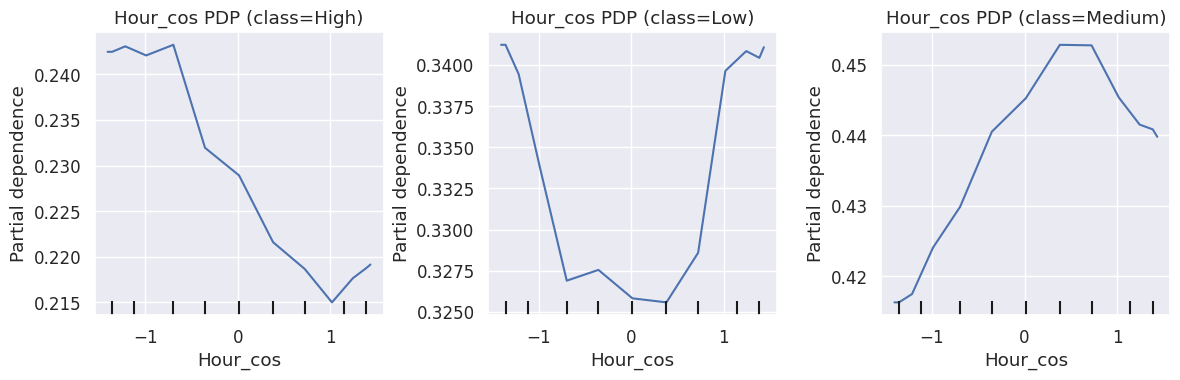

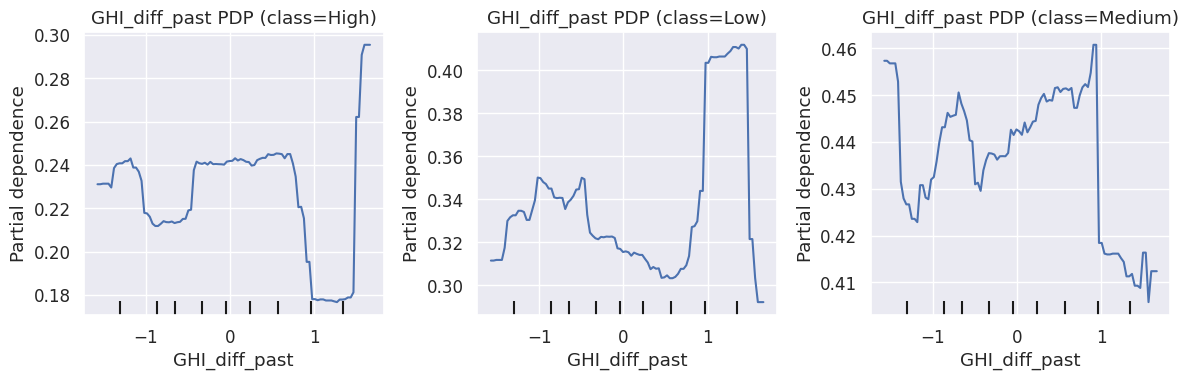

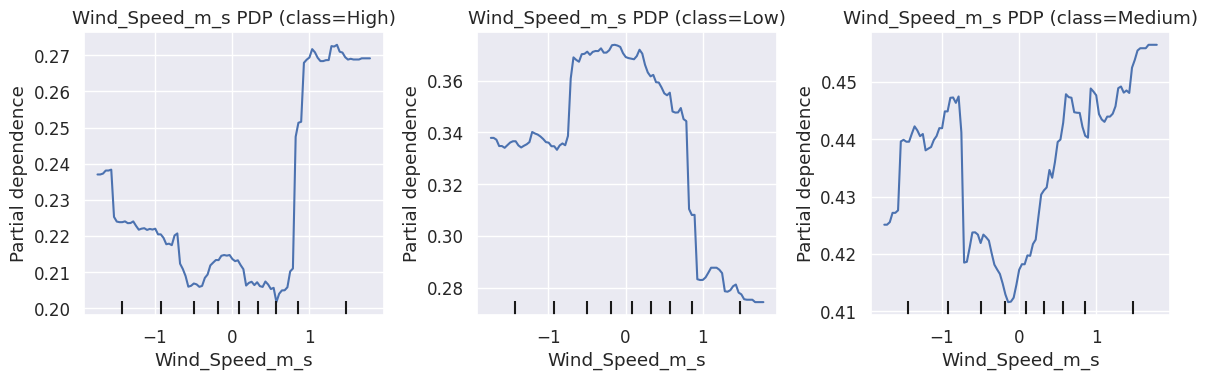


🔍 Feature importance comparison (SHAP vs Permutation):


,Random Forest SHAP,Random Forest Permutation,XGBoost SHAP,XGBoost Permutation
0,0.0565,0.0000,0.0422,0.0000
1,0.0521,0.0010,0.0422,0.0000
2,0.0490,0.0000,NaN,NaN
3,0.0499,0.0075,NaN,NaN
6,0.0537,0.0000,0.0423,0.0000
7,0.0555,0.0000,0.0426,0.0000
9,0.0581,0.0000,0.0452,0.0000
10,0.0000,0.0050,0.0000,0.0045
11,0.0000,0.0015,0.0432,0.0000
12,0.0000,0.0025,0.0000,0.0005



🧪 SHAP dependence plot for 'Hour_cos' (XGBoost):


 98%|===================| 589/600 [00:37<00:00]       

Could not generate dependence plot for Hour_cos: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was 1.461432, while the model output was 1.397668. If this difference is acceptable you can set check_additivity=False to disable this check.


In [ ]:
# ============================================================
# Cell 13: Explainability & Feature Interpretability (Fixed)
# ============================================================

import joblib
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import classification_report

sns.set_context("notebook", font_scale=1.1)

# ---- 1. Load models/artifacts (reuse if in memory) ----
rf = rf if 'rf' in globals() else joblib.load("rf_model_ghi_class.pkl")
xgb = xgb if 'xgb' in globals() else joblib.load("xgb_advanced_model.pkl")
scaler = scaler if 'scaler' in globals() else joblib.load("scaler.pkl")
label_encoder = label_encoder if 'label_encoder' in globals() else joblib.load("label_encoder.pkl")

# ---- 2. Determine base features for evaluation (consistent with training) ----
try:
    with open("feature_list_xgb.json", "r") as f:
        feature_list = json.load(f)
    print("✅ Loaded feature_list_xgb.json")
except Exception:
    feature_list = None
    print("⚠️ feature_list_xgb.json missing; falling back to scaler or train data")

if hasattr(scaler, "feature_names_in_"):
    base_features = list(scaler.feature_names_in_)
elif feature_list is not None:
    base_features = feature_list
else:
    base_features = X_train.select_dtypes(include=[np.number]).columns.tolist()

# ---- 3. Prepare evaluation data ----
# Use the test split; ensure all expected columns for each model are present
X_eval_full = X_test.copy()  # original (with encoded and raw if available)
y_eval = np.array(y_test, dtype=int)

def get_input_for_model(model, X):
    # Align input to the model's trained feature names, filling missing with 0
    if hasattr(model, "feature_names_in_"):
        return X.reindex(columns=list(model.feature_names_in_), fill_value=0)
    else:
        # fallback to base_features
        return X.reindex(columns=base_features, fill_value=0)

X_rf = get_input_for_model(rf, X_eval_full)
X_xgb = get_input_for_model(xgb, X_eval_full)

# ---- 4. SHAP explanations with safe fallback ----
def compute_shap(model, model_name, X_input, background):
    """
    Attempts SHAP explanation; if it fails (additivity or otherwise), falls back to
    feature_importances_ and returns a DataFrame with Mean |SHAP| analog.
    """
    df_shap = None
    try:
        # build explainer with background; shap.Explainer chooses appropriate internal logic
        explainer = shap.Explainer(model, background, feature_perturbation="interventional")
        # subset for performance
        X_subset = X_input if len(X_input) <= 500 else X_input.sample(500, random_state=42)
        shap_exp = explainer(X_subset)  # shap.Explanation

        # get mean absolute shap per feature (multiclass returns array shaped [samples, features, classes?] in new API)
        # use shap_exp.values: if multioutput, shap_exp.values is array or list-like
        if isinstance(shap_exp.values, list):
            # old API
            abs_mean = np.mean([np.mean(np.abs(v), axis=0) for v in shap_exp.values], axis=0)
        else:
            abs_mean = np.mean(np.abs(shap_exp.values), axis=0)

        abs_mean = np.asarray(abs_mean).reshape(-1)
        if abs_mean.shape[0] != X_subset.shape[1]:
            abs_mean = abs_mean[: X_subset.shape[1]]

        df_shap = pd.DataFrame({
            "Feature": X_subset.columns,
            "Mean |SHAP|": abs_mean
        }).sort_values("Mean |SHAP|", ascending=False)

        # summary plot
        print(f"\n🔍 SHAP summary for {model_name}")
        shap.summary_plot(shap_exp, X_subset, class_names=label_encoder.classes_, show=False)
        plt.title(f"SHAP Summary - {model_name}")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ SHAP failed for {model_name} ({e}); falling back to built-in importances.")
        if hasattr(model, "feature_importances_"):
            imp = np.asarray(model.feature_importances_).reshape(-1)
            # Determine the expected feature names for alignment
            if hasattr(model, "feature_names_in_"):
                feats = list(model.feature_names_in_)
            else:
                feats = X_input.columns.tolist()
            if imp.shape[0] != len(feats):
                imp = imp[: len(feats)]
            df_shap = pd.DataFrame({
                "Feature": feats,
                "Mean |SHAP|": imp
            }).sort_values("Mean |SHAP|", ascending=False)
        else:
            df_shap = pd.DataFrame({
                "Feature": X_input.columns,
                "Mean |SHAP|": np.zeros(X_input.shape[1])
            })
    return df_shap

# background sample drawn from training (for interventional explainer)
X_train_full = X_train.copy().reindex(columns=base_features, fill_value=0)
background = X_train_full.sample(n=min(200, len(X_train_full)), random_state=42)

df_shap_rf = compute_shap(rf, "Random Forest", X_rf, background)
df_shap_xgb = compute_shap(xgb, "XGBoost", X_xgb, background)

# ---- 5. Permutation importances ----
print("\n🔁 Permutation importance (RF, XGBoost)")
perm_importance = {}
for name, model, X_in in [
    ("Random Forest", rf, X_rf),
    ("XGBoost", xgb, X_xgb)
]:
    try:
        res = permutation_importance(model, X_in, y_eval, n_repeats=10, random_state=42, n_jobs=-1)
        df_perm = pd.DataFrame({
            "Feature": X_in.columns,
            "Mean Importance": res.importances_mean,
            "Std": res.importances_std
        }).sort_values("Mean Importance", ascending=False)
        perm_importance[name] = df_perm
        print(f"\nTop 8 permutation importances for {name}:")
        display(df_perm.head(8).round(4))
    except Exception as e:
        print(f"⚠️ Permutation importance failed for {name}: {e}")

# ---- 6. Partial dependence plots for top XGBoost SHAP features (per class) ----
top_feats = df_shap_xgb["Feature"].head(3).tolist()
print(f"\n📈 Partial dependence plots for top features (XGBoost SHAP): {top_feats}")

classes = label_encoder.classes_
for feat in top_feats:
    fig, axes = plt.subplots(1, len(classes), figsize=(4 * len(classes), 4), squeeze=False)
    for i, cls in enumerate(classes):
        try:
            PartialDependenceDisplay.from_estimator(
                xgb, X_xgb, [feat], target=i, kind="average", ax=axes[0, i]
            )
            axes[0, i].set_title(f"{feat} PDP (class={cls})")
        except Exception as e:
            axes[0, i].text(0.5, 0.5, "Failed", ha="center")
            print(f"Could not plot PDP for feature '{feat}' class '{cls}': {e}")
    plt.tight_layout()
    plt.show()

# ---- 7. Combined comparison table SHAP vs Permutation ----
def top_n(df, n=10, key=None):
    if key:
        return df.nlargest(n, key)[[key]].rename(columns={key: key})
    else:
        return df.head(n)

comparison_frames = []
for model_name, shap_df in [("Random Forest", df_shap_rf), ("XGBoost", df_shap_xgb)]:
    perm_df = perm_importance.get(model_name)
    if shap_df is None or perm_df is None:
        continue
    comb = pd.DataFrame({
        f"{model_name} SHAP": top_n(shap_df, 10, key="Mean |SHAP|")["Mean |SHAP|"],
        f"{model_name} Permutation": top_n(perm_df, 10, key="Mean Importance")["Mean Importance"]
    }).fillna(0)
    comparison_frames.append(comb)

if comparison_frames:
    print("\n🔍 Feature importance comparison (SHAP vs Permutation):")
    display(pd.concat(comparison_frames, axis=1).round(4))

# ---- 8. SHAP dependence plot for top XGBoost feature ----
if not df_shap_xgb.empty:
    strongest = df_shap_xgb["Feature"].iloc[0]
    print(f"\n🧪 SHAP dependence plot for '{strongest}' (XGBoost):")
    try:
        # rebuild explainer to get shap_values for dependence
        explainer_xgb = shap.Explainer(xgb, background, feature_perturbation="interventional")
        shap_exp_full = explainer_xgb(X_xgb.sample(min(500, len(X_xgb)), random_state=42))
        shap.dependence_plot(strongest, shap_exp_full.values, X_xgb.sample(min(500, len(X_xgb)), random_state=42), show=False)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not generate dependence plot for {strongest}: {e}")


## Error Analysis


🧪 Error Analysis for champion: XGB
Classification report:
              precision    recall  f1-score   support

        High       0.17      0.11      0.13        36
         Low       0.33      0.34      0.34        62
      Medium       0.49      0.54      0.51       102

    accuracy                           0.40       200
   macro avg       0.33      0.33      0.33       200
weighted avg       0.38      0.40      0.39       200



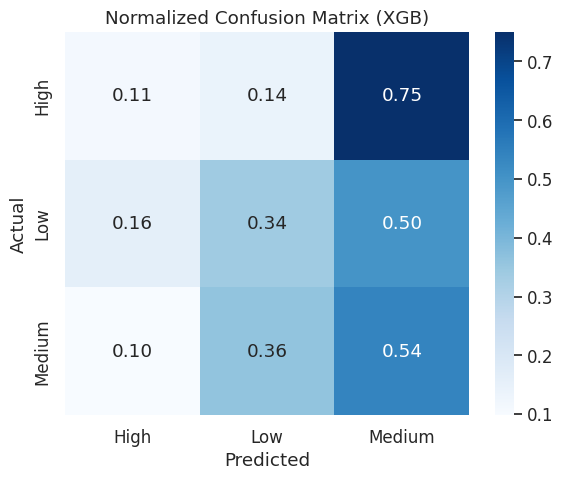


Top misclassification types (true→pred):
Error_Type
Medium→Low     37
Low→Medium     31
High→Medium    27
Low→High       10
Medium→High    10
High→Low        5


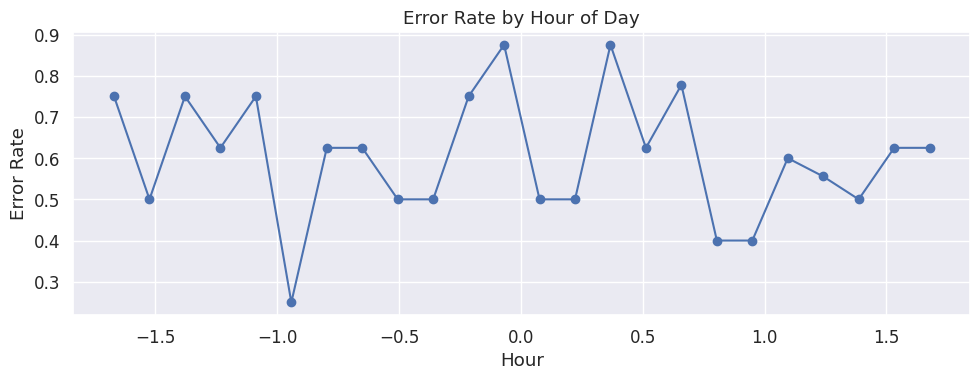

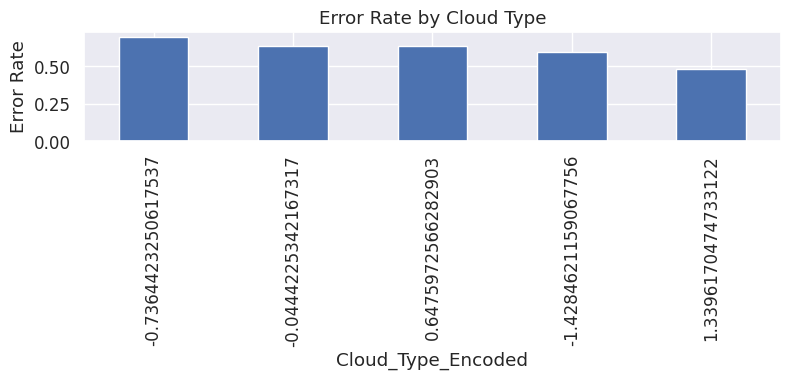

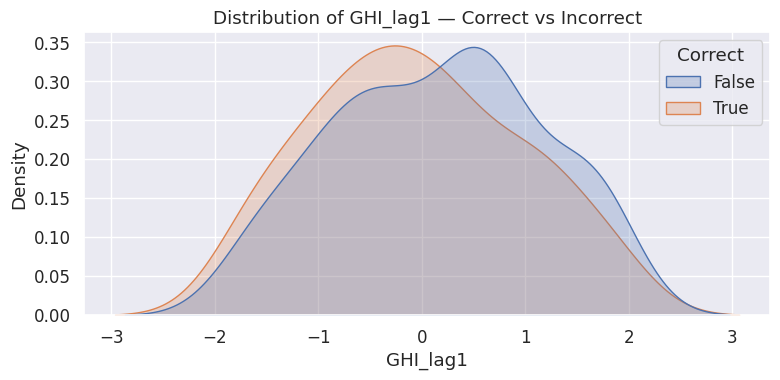

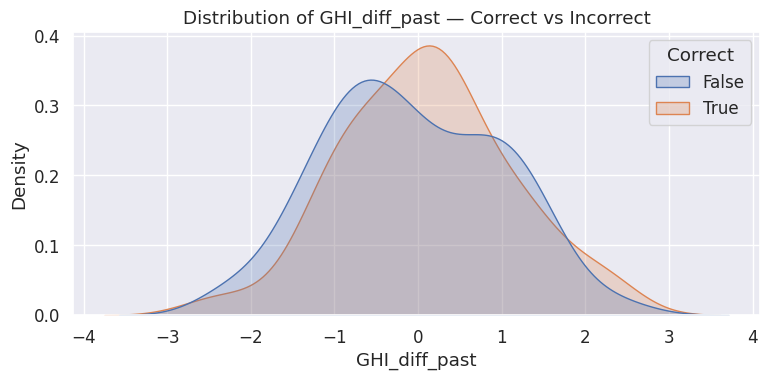

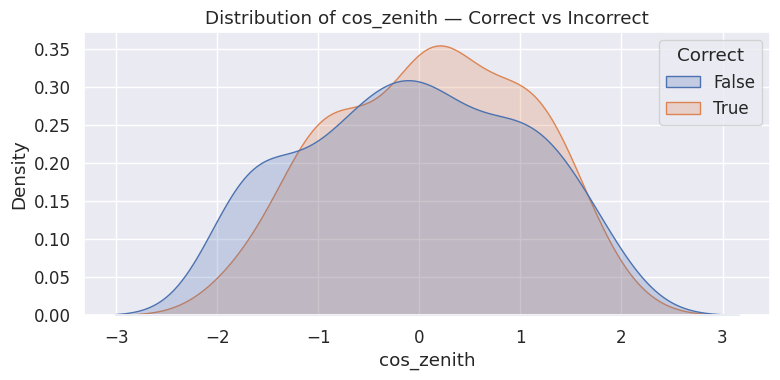

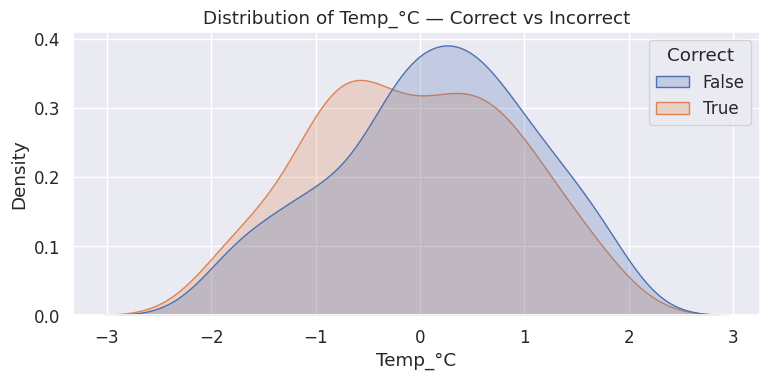

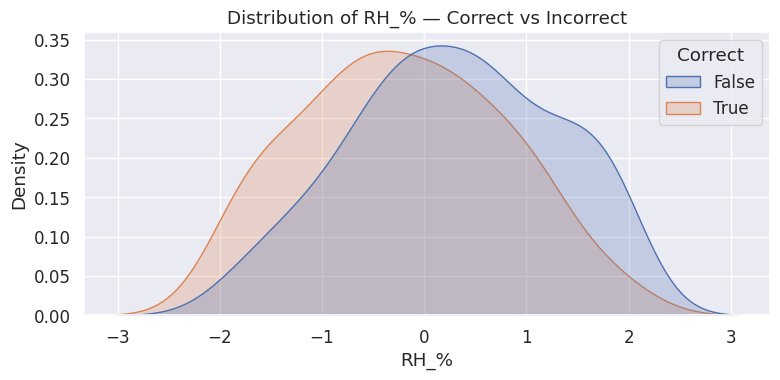

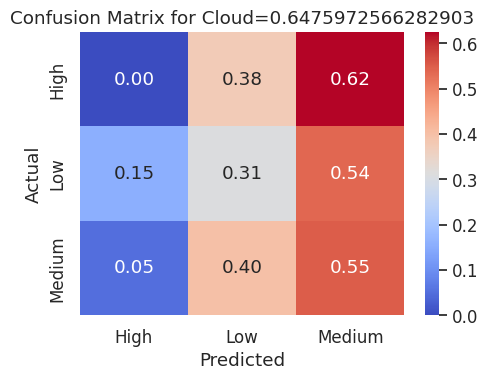

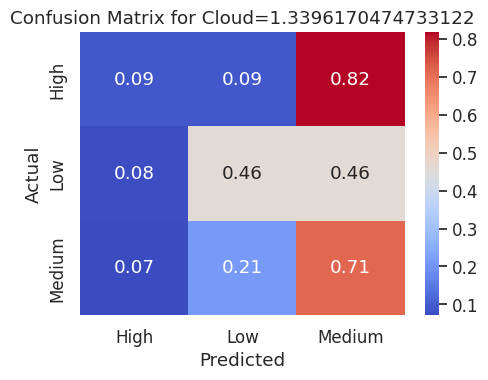

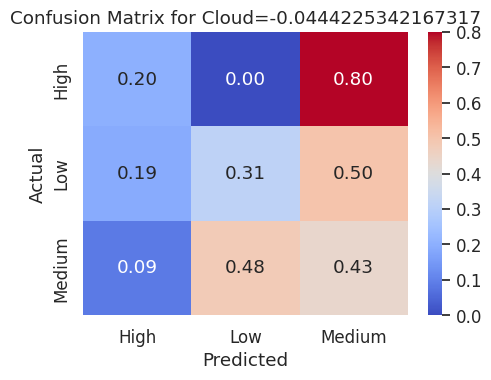

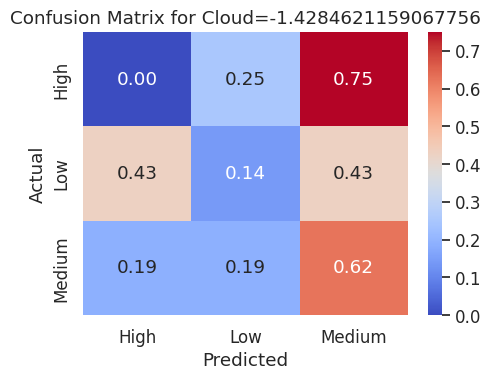

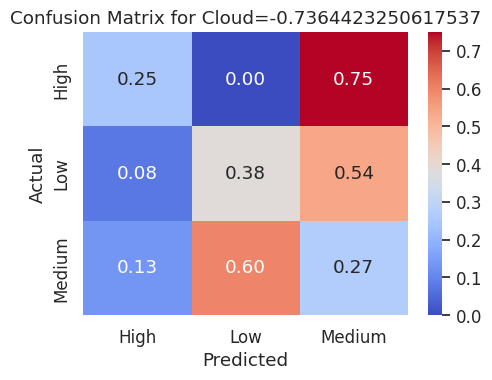


🔍 Sample misclassifications (showing up to 5 per common type):

Error type: Medium→Low (showing 5 examples)


,True_Label,Pred_Label,GHI_lag1,GHI_diff_past,cos_zenith,Temp_°C,RH_%,Cloud_Type_Encoded
3,Medium,Low,0.403670,-0.488295,-0.534691,-1.372394,-0.056403,-0.044423
5,Medium,Low,0.727245,-0.859472,-0.354267,0.804108,1.848926,-0.044423
8,Medium,Low,0.845674,-0.779176,1.722379,0.953376,0.456748,-0.044423
10,Medium,Low,1.616544,-1.382960,-1.010734,1.762818,-0.017095,0.647597
16,Medium,Low,0.225441,-1.267160,0.048337,-0.671083,1.172066,-0.736442



Error type: Low→Medium (showing 5 examples)


,True_Label,Pred_Label,GHI_lag1,GHI_diff_past,cos_zenith,Temp_°C,RH_%,Cloud_Type_Encoded
9,Low,Medium,-0.260804,1.324602,-1.774211,-0.163486,0.437306,0.647597
14,Low,Medium,-0.871977,0.785179,0.166977,0.326214,1.486134,-0.044423
20,Low,Medium,-0.172737,-0.108374,0.582021,-1.158213,1.092284,-1.428462
22,Low,Medium,0.427555,-0.686167,-0.405281,-1.463087,0.892369,1.339617
23,Low,Medium,-0.547006,1.668443,-0.938455,-0.747339,1.422285,1.339617



Error type: High→Medium (showing 5 examples)


,True_Label,Pred_Label,GHI_lag1,GHI_diff_past,cos_zenith,Temp_°C,RH_%,Cloud_Type_Encoded
7,High,Medium,1.002096,-0.109330,-0.147616,1.491579,0.505171,0.647597
15,High,Medium,0.240298,-0.009517,1.090002,0.644768,-0.662609,-1.428462
21,High,Medium,-0.327805,0.533532,0.662900,0.779445,1.848926,-1.428462
32,High,Medium,0.538726,-0.726071,0.005637,-0.238938,0.613946,1.339617
33,High,Medium,-0.492432,0.738785,0.000796,1.198247,-1.329585,-0.736442


In [ ]:
# ============================================================
# Cell 14: Error Analysis
# Purpose: Diagnose where the champion model fails, patterns in misclassification
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

sns.set_context("notebook", font_scale=1.1)

# ---- 0. Choose champion model (must match what was used in Cell 12/11) ----
champion_key = 'xgb'  # or 'rf'; adjust if you want to analyze a different model
model = None
if champion_key.lower() == 'xgb' and 'xgb' in globals():
    model = xgb
elif champion_key.lower() == 'rf' and 'rf' in globals():
    model = rf
elif champion_key.lower() == 'lstm' and 'lstm' in globals():
    model = lstm
else:
    raise RuntimeError(f"Champion model '{champion_key}' not loaded or unknown.")

# ---- 1. Get predictions & build error DataFrame ----
# Prepare test features aligned to model (same logic as evaluation)
def align_for_model(m, X):
    if hasattr(m, "feature_names_in_"):
        return X.reindex(columns=list(m.feature_names_in_), fill_value=0)
    return X.copy()

if champion_key.lower() in ['xgb', 'rf']:
    X_input = align_for_model(model, X_test)
    y_pred = model.predict(X_input)
elif champion_key.lower() == 'lstm':
    # assume X_te_seq was built earlier for LSTM
    y_pred = np.argmax(model.predict(X_te_seq), axis=1)
else:
    raise RuntimeError("Unsupported champion_key for error analysis.")

y_true = np.array(y_test, dtype=int)
y_pred_decoded = label_encoder.inverse_transform(y_pred)
y_true_decoded = label_encoder.inverse_transform(y_true)

# Build DataFrame for analysis
err_df = X_test.copy().reset_index(drop=True)
err_df['True_Label'] = y_true_decoded
err_df['Pred_Label'] = y_pred_decoded
err_df['Correct'] = err_df['True_Label'] == err_df['Pred_Label']
err_df['Error_Type'] = err_df.apply(lambda r: f"{r['True_Label']}→{r['Pred_Label']}" if not r['Correct'] else "Correct", axis=1)

# ---- 2. Summary statistics ----
print(f"\n🧪 Error Analysis for champion: {champion_key.upper()}")
print("Classification report:")
print(classification_report(y_true_decoded, y_pred_decoded, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(y_true_decoded, y_pred_decoded, labels=label_encoder.classes_)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(f"Normalized Confusion Matrix ({champion_key.upper()})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ---- 3. Most common misclassification pairs ----
mis_pairs = err_df[~err_df['Correct']]['Error_Type'].value_counts().head(10)
print("\nTop misclassification types (true→pred):")
print(mis_pairs.to_string())

# ---- 4. Error rate by hour of day (if feature exists) ----
if 'Hour' in err_df.columns:
    summary_by_hour = err_df.groupby('Hour').agg(
        total=('Correct', 'size'),
        correct=('Correct', 'sum')
    )
    summary_by_hour['error_rate'] = 1 - summary_by_hour['correct'] / summary_by_hour['total']
    plt.figure(figsize=(10,4))
    plt.plot(summary_by_hour.index, summary_by_hour['error_rate'], marker='o')
    plt.title("Error Rate by Hour of Day")
    plt.xlabel("Hour")
    plt.ylabel("Error Rate")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---- 5. Error distribution across cloud types (if available) ----
# Prefer the encoded version if present
cloud_col = None
if 'Cloud_Type_Encoded' in err_df.columns:
    cloud_col = 'Cloud_Type_Encoded'
elif 'Cloud_Type' in err_df.columns:
    cloud_col = 'Cloud_Type'

if cloud_col:
    grouped = err_df.groupby(cloud_col).agg(
        total=('Correct', 'size'),
        correct=('Correct', 'sum')
    )
    grouped['error_rate'] = 1 - grouped['correct'] / grouped['total']
    plt.figure(figsize=(8,4))
    grouped['error_rate'].sort_values(ascending=False).plot.bar()
    plt.title("Error Rate by Cloud Type")
    plt.ylabel("Error Rate")
    plt.xlabel(cloud_col)
    plt.tight_layout()
    plt.show()

# ---- 6. Feature distribution for correct vs incorrect ----
key_feats = []
for f in ['GHI_lag1', 'GHI_diff_past', 'cos_zenith', 'Temp_°C', 'RH_%']:
    if f in err_df.columns:
        key_feats.append(f)

for feat in key_feats:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=err_df, x=feat, hue='Correct', common_norm=False, fill=True)
    plt.title(f"Distribution of {feat} — Correct vs Incorrect")
    plt.tight_layout()
    plt.show()

# ---- 7. Confusion conditioned on cloud type (heatmap) ----
if cloud_col:
    for cloud_val in err_df[cloud_col].unique():
        subset = err_df[err_df[cloud_col] == cloud_val]
        if subset.empty:
            continue
        cm_sub = confusion_matrix(subset['True_Label'], subset['Pred_Label'],
                                  labels=label_encoder.classes_)
        cm_sub_norm = cm_sub.astype(float) / np.maximum(cm_sub.sum(axis=1, keepdims=True), 1)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_sub_norm, annot=True, fmt=".2f", cmap='coolwarm',
                    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.title(f"Confusion Matrix for Cloud={cloud_val}")
        plt.xlabel("Predicted"); plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()

# ---- 8. Example failure cases ----
print("\n🔍 Sample misclassifications (showing up to 5 per common type):")
top_errors = err_df[~err_df['Correct']]['Error_Type'].value_counts().index.tolist()[:3]
for et in top_errors:
    subset = err_df[err_df['Error_Type'] == et].head(5)
    print(f"\nError type: {et} (showing {len(subset)} examples)")
    display(subset[[ 'True_Label', 'Pred_Label'] + key_feats + ([cloud_col] if cloud_col else [])])


## Final Model Retraining & TimeSeriesSplit CV

Interpretability Analysis

Data splits (chronological): train=697, calib=150, test=150
▶ Trained base XGB on first 70% of data.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✔ Fitted Platt scaling (multinomial logistic) on calibration slice.

📊 Test set performance (final 15%)
Uncalibrated XGB Accuracy:    0.5133, Weighted F1: 0.4573
Calibrated XGB Accuracy:      0.5133, Weighted F1: 0.3483

Uncalibrated classification report:
              precision    recall  f1-score   support

        High       0.20      0.04      0.07        25
         Low       0.48      0.29      0.36        48
      Medium       0.53      0.81      0.64        77

    accuracy                           0.51       150
   macro avg       0.41      0.38      0.36       150
weighted avg       0.46      0.51      0.46       150

Calibrated classification report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        25
         Low       0.00      0.00      0.00        48
      Medium       0.51      1.00      0.68        77

    accuracy                           0.51       150
   macro avg       0.17      0.33      0.23       150
we

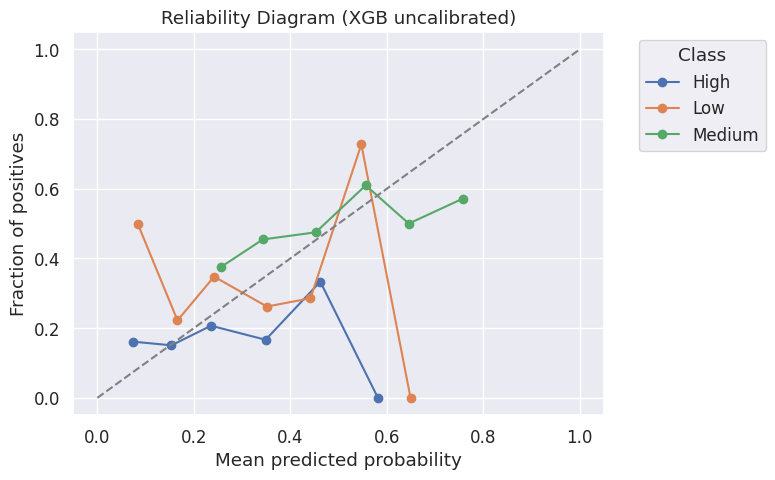

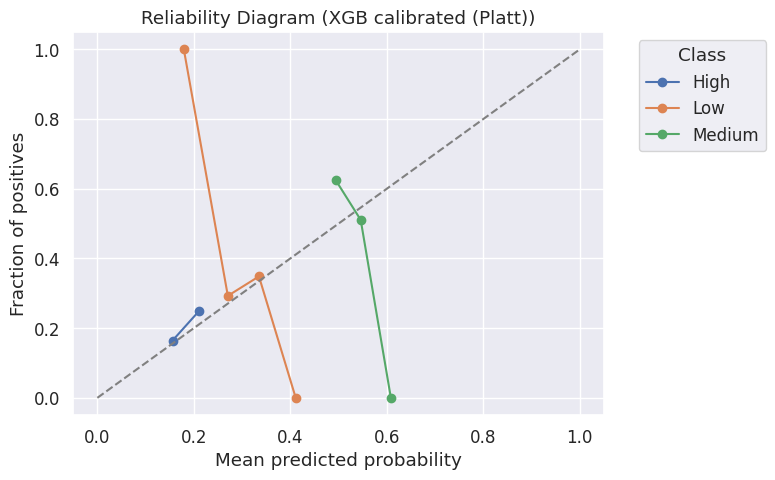


Brier score: uncalibrated=0.2070, calibrated=0.2033

💾 Saved:
 - Base champion (trained on first 70%): platt_xgb_base_train.pkl
 - Platt calibrator: platt_xgb_scaler.pkl


In [ ]:
# ============================================================
# Cell 15 (alt): Final Champion + Manual Platt Scaling with Temporal Hold-out
# Purpose: Train on past, calibrate on immediate future (no leakage), evaluate on later data
# ============================================================

import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    brier_score_loss, confusion_matrix
)
from sklearn.preprocessing import label_binarize
from sklearn.calibration import calibration_curve

sns.set_context("notebook", font_scale=1.1)

# ----- 0. Setup champion -----
champion_key = 'xgb'  # or 'rf'; manual Platt scaling best works with base model that can output decision scores
if champion_key.lower() == 'xgb':
    from xgboost import XGBClassifier
    try:
        base_saved = joblib.load("xgb_advanced_model.pkl")
    except:
        raise RuntimeError("XGBoost model not found; ensure prior cell produced xgb_advanced_model.pkl")
    params = base_saved.get_params()
    champion_base = XGBClassifier(**params)
elif champion_key.lower() == 'rf':
    from sklearn.ensemble import RandomForestClassifier
    try:
        base_saved = joblib.load("rf_model_ghi_class.pkl")
    except:
        raise RuntimeError("Random Forest model not found; ensure prior cell produced rf_model_ghi_class.pkl")
    params = base_saved.get_params()
    champion_base = RandomForestClassifier(**params)
else:
    raise ValueError("champion_key must be 'xgb' or 'rf'.")

# ----- 1. Prepare chronological splits -----
if 'X_final' not in globals() or 'y_final' not in globals():
    raise RuntimeError("X_final / y_final missing. Run Feature Engineering cell first.")

X = X_final.copy()
y = y_final.copy()

# Drop any object columns if present
for col in X.select_dtypes(include=['object']).columns.tolist():
    X.drop(columns=[col], inplace=True)

n = len(X)
train_end = int(0.7 * n)
cal_end = int(0.85 * n)

X_train = X.iloc[:train_end]
y_train = y[:train_end]
X_cal = X.iloc[train_end:cal_end]
y_cal = y[train_end:cal_end]
X_test = X.iloc[cal_end:]
y_test = y[cal_end:]

print(f"Data splits (chronological): train={len(X_train)}, calib={len(X_cal)}, test={len(X_test)}")

# ----- 2. Train base champion on training slice -----
champion_base.fit(X_train, y_train)
print(f"▶ Trained base {champion_key.upper()} on first 70% of data.")

# ----- 3. Fit Platt scaling on calibration slice -----
# For multiclass: use raw margins (before softmax/logits) as input to multinomial logistic regression
if champion_key.lower() == 'xgb':
    # output_margin=True gives raw score per class
    margins_cal = champion_base.predict(X_cal, output_margin=True)
else:
    # RandomForest doesn't provide margin directly; use class probabilities' log-odds as proxy
    probs_cal = champion_base.predict_proba(X_cal)
    # clip to avoid logit inf
    eps = 1e-6
    probs_cal_clipped = np.clip(probs_cal, eps, 1 - eps)
    margins_cal = np.log(probs_cal_clipped / (1 - probs_cal_clipped))  # shape (n_samples, n_classes)

# Fit multinomial logistic regression mapping margins -> true label
platt = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000
)
platt.fit(margins_cal, y_cal)
print("✔ Fitted Platt scaling (multinomial logistic) on calibration slice.")

# ----- 4. Evaluate on test slice (uncalibrated vs calibrated) -----
# Uncalibrated predictions/probs
y_pred_uncal = champion_base.predict(X_test)
proba_uncal = champion_base.predict_proba(X_test)

# Calibrated: compute margins then pass through Platt
if champion_key.lower() == 'xgb':
    margins_test = champion_base.predict(X_test, output_margin=True)
else:
    probs_test = champion_base.predict_proba(X_test)
    probs_test_clipped = np.clip(probs_test, eps, 1 - eps)
    margins_test = np.log(probs_test_clipped / (1 - probs_test_clipped))

proba_calibrated = platt.predict_proba(margins_test)
y_pred_cal = np.argmax(proba_calibrated, axis=1)

# Metrics
acc_uncal = accuracy_score(y_test, y_pred_uncal)
f1_uncal = f1_score(y_test, y_pred_uncal, average='weighted')
acc_cal = accuracy_score(y_test, y_pred_cal)
f1_cal = f1_score(y_test, y_pred_cal, average='weighted')

print("\n📊 Test set performance (final 15%)")
print(f"Uncalibrated {champion_key.upper()} Accuracy:    {acc_uncal:.4f}, Weighted F1: {f1_uncal:.4f}")
print(f"Calibrated {champion_key.upper()} Accuracy:      {acc_cal:.4f}, Weighted F1: {f1_cal:.4f}")

print("\nUncalibrated classification report:")
print(classification_report(y_test, y_pred_uncal, target_names=label_encoder.classes_))
print("Calibrated classification report:")
print(classification_report(y_test, y_pred_cal, target_names=label_encoder.classes_))

# ----- 5. Calibration diagnostics: reliability diagrams & Brier -----
classes = label_encoder.classes_
y_test_bin = label_binarize(y_test, classes=np.arange(len(classes)))

def reliable_plot(y_true_bin, probs, title):
    plt.figure(figsize=(8,5))
    for i, cls in enumerate(classes):
        prob_pos = probs[:, i]
        true_label = y_true_bin[:, i]
        frac_pos, mean_pred = calibration_curve(true_label, prob_pos, n_bins=10, strategy="uniform")
        plt.plot(mean_pred, frac_pos, marker='o', label=cls)
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.title(f"Reliability Diagram ({title})")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.legend(title="Class", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n📉 Reliability diagrams:")
reliable_plot(y_test_bin, proba_uncal, f"{champion_key.upper()} uncalibrated")
reliable_plot(y_test_bin, proba_calibrated, f"{champion_key.upper()} calibrated (Platt)")

def multiclass_brier(y_bin, probs):
    return np.mean([brier_score_loss(y_bin[:, i], probs[:, i]) for i in range(y_bin.shape[1])])

brier_uncal = multiclass_brier(y_test_bin, proba_uncal)
brier_cal = multiclass_brier(y_test_bin, proba_calibrated)
print(f"\nBrier score: uncalibrated={brier_uncal:.4f}, calibrated={brier_cal:.4f}")

# ----- 6. Save artifacts -----
joblib.dump(champion_base, f"platt_{champion_key}_base_train.pkl")
joblib.dump(platt, f"platt_{champion_key}_scaler.pkl")
print("\n💾 Saved:")
print(f" - Base champion (trained on first 70%): platt_{champion_key}_base_train.pkl")
print(f" - Platt calibrator: platt_{champion_key}_scaler.pkl")


Loaded scaler from scaler.pkl
Loaded label encoder from label_encoder.pkl
Using manual Platt-scaled XGBoost pipeline (base + logistic).

Inference output on example inputs:


,Predicted,Confidence,P(High),P(Low),P(Medium)
850,Medium,0.549014,0.153830,0.297156,0.549014
851,Medium,0.561391,0.149980,0.288629,0.561391
852,Medium,0.547953,0.181997,0.270050,0.547953
853,Medium,0.533756,0.168657,0.297588,0.533756
854,Medium,0.497482,0.121629,0.380889,0.497482



SHAP for first example (tree-based):
SHAP explanation summary:


/tmp/ipython-input-2669045028.py:176: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, pd.DataFrame(X_aligned, columns=X_aligned.columns), max_display=top_n, show=False)


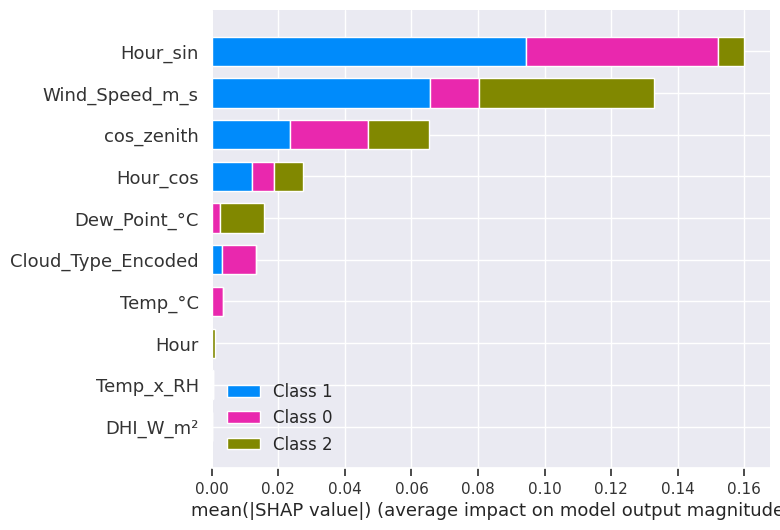

SHAP explain failed: index 40 is out of bounds for axis 0 with size 26


In [ ]:

# ============================================================
# Cell 16: Inference Pipeline for Champion Model
# Purpose: Load saved artifacts, preprocess new data, provide prediction + calibrated probability + optional SHAP explanation
# ============================================================

import joblib
import os
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.1)

# -------- 1. Load available artifacts --------
# Scaler & label encoder (try final versions first)
scaler = None
label_encoder = None
for fname in ["scaler_final.pkl", "scaler.pkl"]:
    if os.path.exists(fname):
        scaler = joblib.load(fname)
        print(f"Loaded scaler from {fname}")
        break
if scaler is None:
    raise FileNotFoundError("Scaler not found. Run preprocessing/feature-engineering cell to create it.")

for fname in ["label_encoder_final.pkl", "label_encoder.pkl"]:
    if os.path.exists(fname):
        label_encoder = joblib.load(fname)
        print(f"Loaded label encoder from {fname}")
        break
if label_encoder is None:
    raise FileNotFoundError("Label encoder not found.")

# Try to load calibrated classifier first, otherwise fallback to manual Platt or base
champion = None
calibrator = None
platt_calibrator = None
use_manual_platt = False

# CalibratedClassifierCV artifact
for model_name in ["final_xgb_calibrated_model.pkl", "final_rf_calibrated_model.pkl"]:
    if os.path.exists(model_name):
        champion = joblib.load(model_name)
        print(f"Using calibrated champion model from {model_name}")
        break

# Manual Platt scaling artifacts (temporal version)
if champion is None:
    # try manual Platt base + logistic
    if os.path.exists("platt_xgb_base_train.pkl") and os.path.exists("platt_xgb_scaler.pkl"):
        from xgboost import XGBClassifier
        champion = joblib.load("platt_xgb_base_train.pkl")
        platt_calibrator = joblib.load("platt_xgb_scaler.pkl")
        use_manual_platt = True
        print("Using manual Platt-scaled XGBoost pipeline (base + logistic).")
    elif os.path.exists("platt_rf_base_train.pkl") and os.path.exists("platt_rf_scaler.pkl"):
        from sklearn.ensemble import RandomForestClassifier
        champion = joblib.load("platt_rf_base_train.pkl")
        platt_calibrator = joblib.load("platt_rf_scaler.pkl")
        use_manual_platt = True
        print("Using manual Platt-scaled Random Forest pipeline (base + logistic).")
    else:
        # Fallback to base champion
        if os.path.exists("final_xgb_base_model.pkl"):
            champion = joblib.load("final_xgb_base_model.pkl")
            print("Using base XGBoost champion (no calibration).")
        elif os.path.exists("final_rf_base_model.pkl"):
            champion = joblib.load("final_rf_base_model.pkl")
            print("Using base Random Forest champion (no calibration).")
        elif os.path.exists("xgb_advanced_model.pkl"):
            champion = joblib.load("xgb_advanced_model.pkl")
            print("Using saved XGBoost model (un-calibrated).")
        elif os.path.exists("rf_model_ghi_class.pkl"):
            champion = joblib.load("rf_model_ghi_class.pkl")
            print("Using saved Random Forest model (un-calibrated).")
        else:
            raise FileNotFoundError("No champion model file found.")

# -------- 2. Preprocessing helper --------
def preprocess_new_data(df_new):
    """
    Aligns new raw feature DataFrame to training schema: fills missing cols, drops unexpected.
    Applies scaler. Returns scaled array and aligned DataFrame.
    """
    # Align columns to scaler / training feature names
    if hasattr(scaler, "feature_names_in_"):
        expected_cols = list(scaler.feature_names_in_)
    else:
        # fallback to whatever champion expects
        if hasattr(champion, "feature_names_in_"):
            expected_cols = list(champion.feature_names_in_)
        else:
            expected_cols = df_new.select_dtypes(include=[np.number]).columns.tolist()

    X_aligned = df_new.reindex(columns=expected_cols, fill_value=0)
    X_scaled = scaler.transform(X_aligned)
    return X_scaled, X_aligned

# -------- 3. Prediction wrapper --------
def predict_ghi_category(df_new):
    """
    Input: new data DataFrame with same feature names before scaling.
    Output: DataFrame with predicted class, probability (calibrated if available), and raw scores.
    """
    X_scaled, X_aligned = preprocess_new_data(df_new)
    # If the model is a calibrated classifier, predict_proba is calibrated already
    if use_manual_platt:
        # Get base probabilities or margins
        if hasattr(champion, "predict"):
            # for XGBoost, we can get raw margin then apply Platt
            try:
                margins = champion.predict(df_new.reindex(columns=X_aligned.columns, fill_value=0), output_margin=True)
            except Exception:
                probs = champion.predict_proba(X_scaled)
                eps = 1e-6
                probs_clipped = np.clip(probs, eps, 1 - eps)
                margins = np.log(probs_clipped / (1 - probs_clipped))
        else:
            margins = champion.predict_proba(X_scaled)  # fallback
        calibrated_proba = platt_calibrator.predict_proba(margins)
        pred_idx = np.argmax(calibrated_proba, axis=1)
        pred_label = label_encoder.inverse_transform(pred_idx)
        confidence = calibrated_proba.max(axis=1)
        raw_proba = champion.predict_proba(X_scaled) if hasattr(champion, "predict_proba") else None
    else:
        proba = champion.predict_proba(X_scaled)
        pred_idx = np.argmax(proba, axis=1)
        pred_label = label_encoder.inverse_transform(pred_idx)
        confidence = proba.max(axis=1)
        calibrated_proba = proba
        raw_proba = proba

    out = pd.DataFrame({
        "Predicted": pred_label,
        "Confidence": confidence
    }, index=df_new.index)

    # attach full probability vector
    for i, cls in enumerate(label_encoder.classes_):
        out[f"P({cls})"] = calibrated_proba[:, i]

    return out, X_aligned

# -------- 4. Optional: SHAP explanation for a single sample --------
def shap_explain(sample_df, model=champion, background_samples=None, top_n=10):
    """
    Provide SHAP explanation for one or more samples. sample_df should be raw (pre-scaling) DataFrame.
    """
    X_scaled, X_aligned = preprocess_new_data(sample_df)
    # Build background if not provided
    if background_samples is None:
        # sample from training data
        if 'X_train' in globals():
            bg = X_train.sample(n=min(200, len(X_train)), random_state=42)
            if hasattr(scaler, "transform"):
                bg_scaled = scaler.transform(bg.reindex(columns=X_aligned.columns, fill_value=0))
                try:
                    explainer = shap.Explainer(model, bg_scaled)
                    shap_values = explainer(X_scaled)
                except Exception:
                    explainer = shap.Explainer(model, bg)
                    shap_values = explainer(X_aligned)
            else:
                explainer = shap.Explainer(model, bg)
                shap_values = explainer(X_aligned)
        else:
            raise RuntimeError("No training data in scope to sample background for SHAP.")
    else:
        explainer = shap.Explainer(model, background_samples)
        shap_values = explainer(X_scaled)

    # Summary for the sample(s)
    print("SHAP explanation summary:")
    shap.summary_plot(shap_values, pd.DataFrame(X_aligned, columns=X_aligned.columns), max_display=top_n, show=False)
    plt.tight_layout()
    plt.show()

    # Force dependence for top feature
    if hasattr(shap_values, 'values'):
        feature_idx = np.argmax(np.mean(np.abs(shap_values.values), axis=0))
        feat = X_aligned.columns[feature_idx]
        print(f"\nDependence plot for top feature: {feat}")
        try:
            shap.dependence_plot(feat, shap_values.values, pd.DataFrame(X_aligned, columns=X_aligned.columns), show=False)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print("Dependence plot failed:", e)

# -------- 5. Example usage --------
# Replace this with your actual new/raw data (must include same columns prior to scaling)
# Example: take first 5 rows from test split as 'new' inputs
example_raw = X_test.iloc[:5].copy()  # assuming X_test available from previous cells
pred_df, aligned = predict_ghi_category(example_raw)
print("\nInference output on example inputs:")
display(pred_df)

# If tree model, show SHAP for first sample
try:
    print("\nSHAP for first example (tree-based):")
    shap_explain(example_raw.iloc[[0]])
except Exception as e:
    print("SHAP explain failed:", e)


##  Deployment Prototype with FastAPI

In [ ]:
# ============================================================
# Cell 17: Batch Inference + Logging and CSV Export
# Purpose: Run batch predictions, optionally evaluate if true labels available, and persist results
# ============================================================

import os
import time
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ---- Helpers: reuse from Cell 16 if present, else redefine minimal ----
needs_redefine = False
try:
    predict_ghi_category  # exists
except NameError:
    needs_redefine = True

if needs_redefine:
    # Fallback minimal preprocessing/prediction assuming champion, scaler, label_encoder are loaded
    def preprocess_new_data(df_new):
        if hasattr(scaler, "feature_names_in_"):
            expected_cols = list(scaler.feature_names_in_)
        else:
            if hasattr(champion, "feature_names_in_"):
                expected_cols = list(champion.feature_names_in_)
            else:
                expected_cols = df_new.select_dtypes(include=[np.number]).columns.tolist()
        X_aligned = df_new.reindex(columns=expected_cols, fill_value=0)
        X_scaled = scaler.transform(X_aligned)
        return X_scaled, X_aligned

    def predict_ghi_category(df_new):
        X_scaled, X_aligned = preprocess_new_data(df_new)
        if 'use_manual_platt' in globals() and use_manual_platt and platt_calibrator is not None:
            # manual Platt path
            if hasattr(champion, "predict"):
                try:
                    margins = champion.predict(df_new.reindex(columns=X_aligned.columns, fill_value=0), output_margin=True)
                except Exception:
                    probs = champion.predict_proba(X_scaled)
                    eps = 1e-6
                    probs_clipped = np.clip(probs, eps, 1 - eps)
                    margins = np.log(probs_clipped / (1 - probs_clipped))
            else:
                margins = champion.predict_proba(X_scaled)
            calibrated_proba = platt_calibrator.predict_proba(margins)
            pred_idx = np.argmax(calibrated_proba, axis=1)
            pred_label = label_encoder.inverse_transform(pred_idx)
            confidence = calibrated_proba.max(axis=1)
            proba_full = calibrated_proba
        else:
            proba = champion.predict_proba(X_scaled)
            pred_idx = np.argmax(proba, axis=1)
            pred_label = label_encoder.inverse_transform(pred_idx)
            confidence = proba.max(axis=1)
            proba_full = proba

        out = pd.DataFrame({
            "Predicted": pred_label,
            "Confidence": confidence
        }, index=df_new.index)
        for i, cls in enumerate(label_encoder.classes_):
            out[f"P({cls})"] = proba_full[:, i]
        return out, X_aligned

# ---- Main batch inference function ----
def batch_inference(df_new, true_label_col=None, output_csv="batch_predictions.csv", append=False):
    """
    Run predictions on a batch of raw input rows.
    df_new: DataFrame of raw features (before scaling/encoding).
    true_label_col: optional column name in df_new with ground truth integer labels or class names.
    output_csv: path to write predictions.
    append: if True and file exists, append; otherwise overwrite/create.
    Returns: tuple (predictions_df, metrics_dict or None)
    """
    start_time = time.time()
    # Separate true labels if provided
    y_true = None
    if true_label_col is not None and true_label_col in df_new.columns:
        raw_true = df_new[true_label_col]
        # if string labels, convert to encoded
        if raw_true.dtype == object or raw_true.dtype.name.startswith("category"):
            try:
                y_true = label_encoder.transform(raw_true)
            except Exception:
                y_true = raw_true.values  # fallback
        else:
            y_true = raw_true.values

        df_input = df_new.drop(columns=[true_label_col]).copy()
    else:
        df_input = df_new.copy()

    # Predict
    preds_df, aligned = predict_ghi_category(df_input)

    # Attach timestamp and true label if any
    preds_df = preds_df.reset_index(drop=True)
    df_input = df_input.reset_index(drop=True)
    result = pd.concat([df_input, preds_df], axis=1)
    result["Inference_Timestamp"] = datetime.utcnow().isoformat()
    if y_true is not None:
        # decode true if integer to human label
        try:
            true_decoded = label_encoder.inverse_transform(y_true.astype(int))
        except Exception:
            true_decoded = y_true
        result["True_Label"] = true_decoded

    # Metrics if ground truth available
    metrics = None
    if y_true is not None:
        # Convert predicted labels to encoded for comparison
        y_pred_enc = label_encoder.transform(result["Predicted"])
        # If y_true is already encoded integers, use directly; else attempt mapping
        y_true_enc = y_true
        acc = accuracy_score(y_true_enc, y_pred_enc)
        f1w = f1_score(y_true_enc, y_pred_enc, average='weighted')
        metrics = {
            "accuracy": acc,
            "weighted_f1": f1w,
            "classification_report": classification_report(
                y_true_enc, y_pred_enc, target_names=label_encoder.classes_, output_dict=True
            )
        }
        print(f"\n🧪 Batch Evaluation: accuracy={acc:.4f}, weighted_f1={f1w:.4f}")
        print(classification_report(y_true_enc, y_pred_enc, target_names=label_encoder.classes_))

    # Save to CSV
    mode = "a" if (append and os.path.exists(output_csv)) else "w"
    header = not (append and os.path.exists(output_csv))
    result.to_csv(output_csv, mode=mode, index=False, header=header)
    print(f"\n💾 Saved batch predictions to '{output_csv}' (append={append})")
    elapsed = time.time() - start_time
    print(f"⏱ Batch inference took {elapsed:.2f}s for {len(df_new)} samples.")

    # Simple distribution summary
    print("\n📊 Prediction distribution:")
    print(result["Predicted"].value_counts(normalize=True).round(3).to_string())

    return result, metrics

# ---- Example usage ----
# Simulate batch: use test set (needs the original true category if available)
if 'X_test' in globals():
    # If y_test is encoded integer, convert to class name column
    example_batch = X_test.copy()
    # If you have the true label column (e.g., GHI_Category), attach it for evaluation
    # Here we assume y_test (encoded) is available
    try:
        example_batch["True_Label"] = label_encoder.inverse_transform(y_test)
    except:
        example_batch["True_Label"] = y_test

    preds, metrics = batch_inference(
        example_batch,
        true_label_col="True_Label",
        output_csv="batch_preds_test.csv",
        append=False
    )



🧪 Batch Evaluation: accuracy=0.5133, weighted_f1=0.3483
              precision    recall  f1-score   support

        High       0.00      0.00      0.00        25
         Low       0.00      0.00      0.00        48
      Medium       0.51      1.00      0.68        77

    accuracy                           0.51       150
   macro avg       0.17      0.33      0.23       150
weighted avg       0.26      0.51      0.35       150


💾 Saved batch predictions to 'batch_preds_test.csv' (append=False)
⏱ Batch inference took 0.10s for 150 samples.

📊 Prediction distribution:
Predicted
Medium    1.0


In [ ]:
import joblib
from sklearn.preprocessing import LabelEncoder

rf = joblib.load("rf_model_ghi_class.pkl")
xgb = joblib.load("xgb_advanced_model.pkl")
label_encoder = joblib.load("label_encoder.pkl")
# If you have optimized DNN/LSTM saved:
from tensorflow.keras.models import load_model
final_dnn = load_model("final_optimized_dnn_timeaware.keras")  # or optimized_dnn_ghi_classifier.keras if exists
opt_lstm = load_model("optimized_lstm_ghi_classifier.keras")
# Reload test data (X_test, y_test, X_te_seq, y_te_seq) from earlier preprocessing
